# Search for modulated star rotation signals in Mt. Wilson HK project data

Read about the <a href="https://spaceplace.nasa.gov/solar-cycles/en/">solar magnetic activity cycle</a>

Read about the <a href="https://nso.edu/data/historical-data/mount-wilson-observatory-hk-project/">Mt. Wilson HK project</a>, which was designed to detect sunlike magnetic activity cycles in nearby stars

#### Important point: velocity signals from Earthlike planets are not modulated

If a signal we discover is modulated, it does not come from a planet. That means modulation is a potential diagnosis of false positives coming from star rotation.

#### Goal: use the archival Mt. Wilson data, taken between 1966 and 1995, to search for modulated rotation signals

### Set up python environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.timeseries import LombScargle
from IPython.display import Image

plt.rcParams.update({"font.size":16, "axes.labelsize":16, "font.family":"sans-serif", "font.sans-serif":"Arial"})

### What does a modulated rotation signal look like in the time domain?

A modulated signal is something with the form 

$f(t) = A \sin (2 \pi f_r t - \phi_1) \: \sin (2 \pi f_a t - \phi_2)$, 

where $t$ is time, $f_r$ is the star rotation frequency (1 / rotation period) and $f_a$ is the activity cycle frequency (1 / activity cycle period). During certain parts of the magnetic activity cycle, the star has more starspots, so the amplitude of the rotation signal is higher.

The plot below is a demonstration of what a modulated rotation signal could look like.

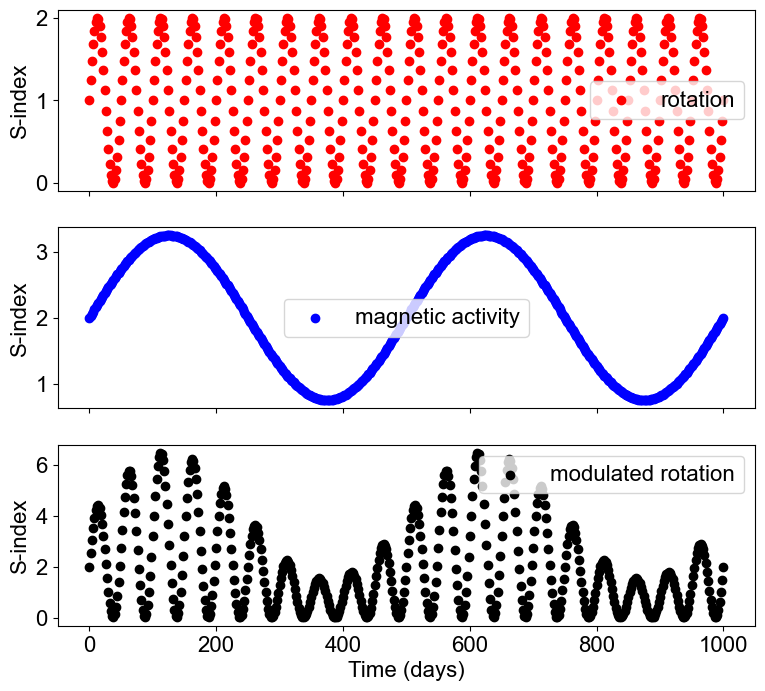

In [2]:
t = np.linspace(0, 1000, num=501, endpoint=True) # simulated data with 1 observation every 2 days
f_rot = 1/50 # 50-day rotation period
f_activity = 1/500 # ~1.5-year activity cycle, which is shorter than the sun's
rotation = 1 + np.sin(2*np.pi*f_rot*t) # S-index cannot be negative, which is why I added 1
activity = 2 + 1.25 * np.sin(2*np.pi*f_activity*t)
modulated_signal = rotation * activity

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(9,8))
ax1.scatter(t, rotation, color='r', label='rotation')
ax1.set_ylabel('S-index')
ax1.legend(loc='best')
ax2.scatter(t, activity, color='b', label='magnetic activity')
ax2.set_ylabel('S-index')
ax2.legend(loc='best')
ax3.scatter(t, modulated_signal, color='k', label='modulated rotation')
ax3.set_ylabel('S-index')
ax3.set_xlabel('Time (days)')
ax3.legend(loc='best')

### Compare to the SILSO international sunspot number time series

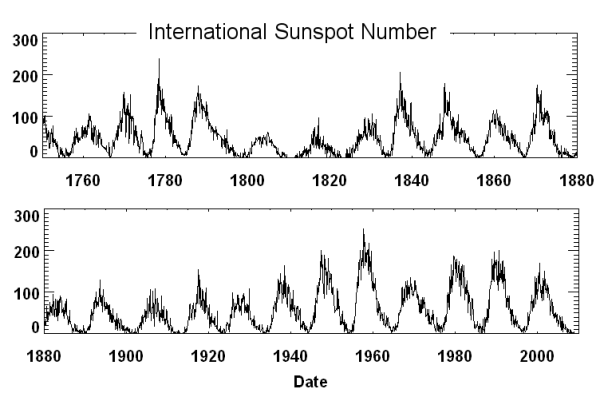

In [3]:
Image(url="https://spaceweather.com/glossary/images2009/zurich_strip.gif", embed=True)

### What does a modulated rotation signal look like in the frequency domain?

Read about <a href="https://www.princeton.edu/~cuff/ele301/files/lecture7_2.pdf">Fourier transforms</a>, <a href="https://web.stat.tamu.edu/~jnewton/stat626/topics/topics/topic4.pdf">periodograms</a>, and <a href="https://arxiv.org/pdf/1703.09824.pdf">Lomb-Scargle periodograms</a>

Here we will use the Lomb-Scargle periodogram to estimate the power spectrum of our rotation, modulation, and modulated rotation signals. Each periodogram shows thresholds for the 1% and 0.1% false alarm levels. Signals that exceed the 0.1% false alarm level are robustly detected. Vertical lines show the rotation frequency (purple dash-dot) and activity cycle frequency (orange dash-dot).

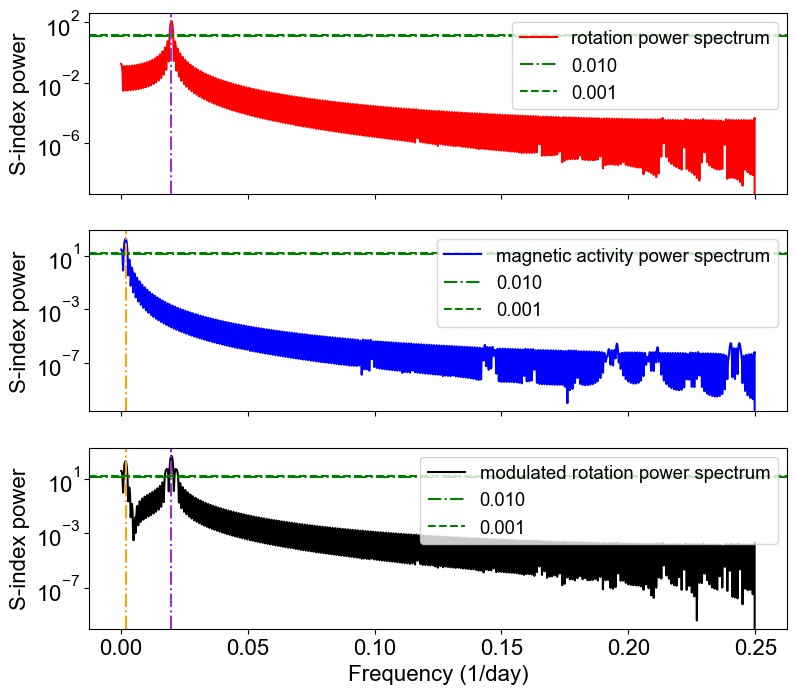

In [4]:
# Make a frequency grid
Rayleigh = 1/1000 # Smallest distinguishable frequency
Nyquist = 0.25 # Largest frequency about which data contains information
fgrid = np.linspace(Rayleigh/5, Nyquist, 1000, endpoint=True)

# Create the Lomb-Scargle periodogram objects
rotation_LS = LombScargle(t, rotation, normalization='psd')
activity_LS = LombScargle(t, activity, normalization='psd')
modulated_signal_LS = LombScargle(t, modulated_signal, normalization='psd')

# From the Lomb-Scargle objects, estimate the power spectrum using the frequency grid specified above
rotation_pow = rotation_LS.power(fgrid)
activity_pow = activity_LS.power(fgrid)
modulated_signal_pow = modulated_signal_LS.power(fgrid)

# Find the false alarm levels associated with each periodogram
faprobs = [0.01, 0.001] # 1% and 0.1% false alarm probabilities
rotation_fals = rotation_LS.false_alarm_level(faprobs)
activity_fals = activity_LS.false_alarm_level(faprobs)
modulated_signal_fals = modulated_signal_LS.false_alarm_level(faprobs)

# Plot
line = ['-.', '--']
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(9,8))

ax1.semilogy(fgrid, rotation_pow, color='r', label='rotation power spectrum')
ax1.set_ylabel('S-index power')
for i in range(len(rotation_fals)):
    ax1.axhline(rotation_fals[i], color='g', ls=line[i], label=f"{faprobs[i]:.3f}")
ax1.axvline(f_rot, color='darkorchid', ls='-.')
ax1.legend(loc='best', fontsize='small')

ax2.semilogy(fgrid, activity_pow, color='b', label='magnetic activity power spectrum')
ax2.set_ylabel('S-index power')
for i in range(len(activity_fals)):
    ax2.axhline(activity_fals[i], color='g', ls=line[i], label=f"{faprobs[i]:.3f}")
ax2.axvline(f_activity, color='orange', ls='-.')
ax2.legend(loc='best', fontsize='small')

ax3.semilogy(fgrid, modulated_signal_pow, color='k', label='modulated rotation power spectrum')
ax3.set_ylabel('S-index power')
ax3.set_xlabel('Frequency (1/day)')
for i in range(len(modulated_signal_fals)):
    ax3.axhline(modulated_signal_fals[i], color='g', ls=line[i], label=f"{faprobs[i]:.3f}")
ax3.axvline(f_rot, color='darkorchid', ls='-.')
ax3.axvline(f_activity, color='orange', ls='-.')
ax3.legend(loc='best', fontsize='small')

### Same plot, just zoomed into low frequencies where our signals are 

### Pay attention to the power spectrum of the modulated rotation signal!

(0.0001, 2000.0)

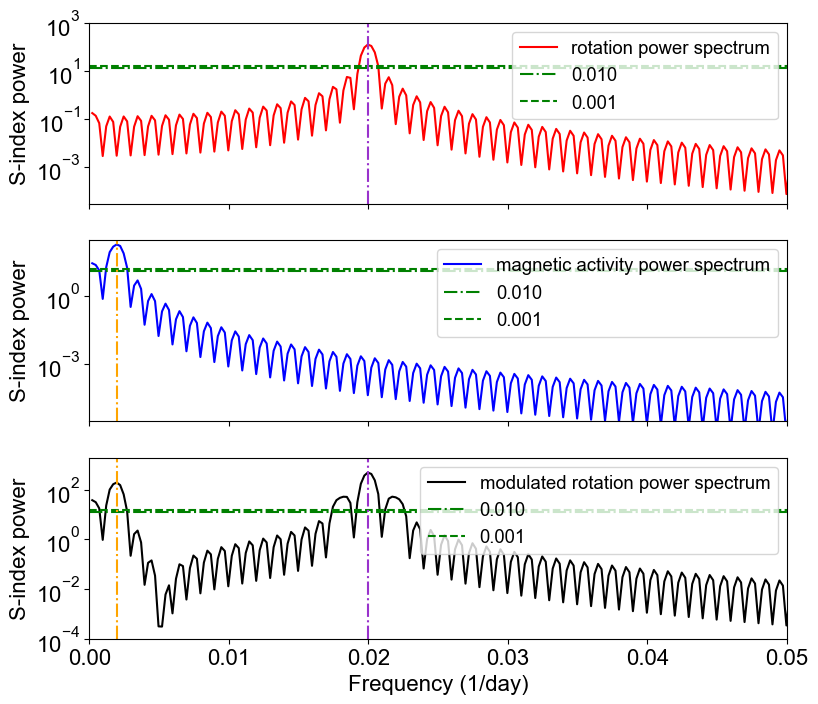

In [5]:
# Plot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(9,8))

ax1.semilogy(fgrid, rotation_pow, color='r', label='rotation power spectrum')
ax1.set_ylabel('S-index power')
for i in range(len(rotation_fals)):
    ax1.axhline(rotation_fals[i], color='g', ls=line[i], label=f"{faprobs[i]:.3f}")
ax1.axvline(f_rot, color='darkorchid', ls='-.')
ax1.legend(loc='best', fontsize='small')
ax1.set_ylim([3e-5, 1e3])

ax2.semilogy(fgrid, activity_pow, color='b', label='magnetic activity power spectrum')
ax2.set_ylabel('S-index power')
for i in range(len(activity_fals)):
    ax2.axhline(activity_fals[i], color='g', ls=line[i], label=f"{faprobs[i]:.3f}")
ax2.axvline(f_activity, color='orange', ls='-.')
ax2.legend(loc='best', fontsize='small')
ax2.set_ylim([3e-6, 3e2])

ax3.semilogy(fgrid, modulated_signal_pow, color='k', label='modulated rotation power spectrum')
ax3.set_ylabel('S-index power')
ax3.set_xlabel('Frequency (1/day)')
for i in range(len(modulated_signal_fals)):
    ax3.axhline(modulated_signal_fals[i], color='g', ls=line[i], label=f"{faprobs[i]:.3f}")
ax3.axvline(f_rot, color='darkorchid', ls='-.')
ax3.axvline(f_activity, color='orange', ls='-.')
ax3.legend(loc='best', fontsize='small')
ax3.set_xlim([0,0.05])
ax3.set_ylim([1e-4, 2e3])

### Why does the estimated power spectrum of the modulated rotation signal have a "trident" centered at the rotation frequency in addition to a peak at the magnetic activity cycle frequency?

## Trig identity: $\sin (\alpha) \sin (\beta) = \frac{\cos (\alpha - \beta) - \cos (\alpha + \beta)}{2}$

The power spectrum doesn't care about the negative sign in front of the second cosine in the trig identity. Remember, $-\cos(x) = \cos(x + \pi)$, and the power spectrum is insensitive to phase shifts.

Thus, instead of getting a power spectrum peak only at the activity cycle frequency like we expected, we get "satellite" peaks of the rotation signal. The satellite peaks are at frequencies $f_r - f_a$ and $f_r + f_a$. Zoom in on bottom plot to see:

(0.0001, 2000.0)

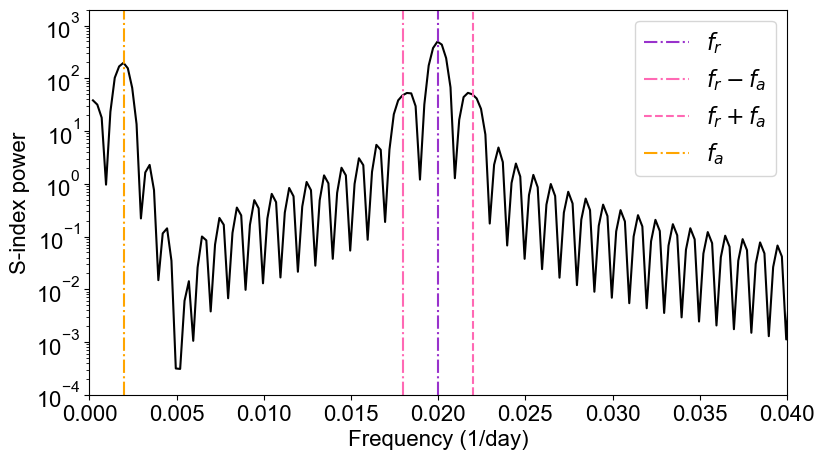

In [6]:
plt.figure(figsize=(9,5))
plt.semilogy(fgrid, modulated_signal_pow, color='k')
plt.ylabel('S-index power')
plt.xlabel('Frequency (1/day)')
plt.axvline(f_rot, color='darkorchid', ls='-.', label=r"$f_r$")
plt.axvline(f_rot - f_activity, color='hotpink', ls='-.', label=r"$f_r - f_a$")
plt.axvline(f_rot + f_activity, color='hotpink', ls='--', label=r"$f_r + f_a$")
plt.axvline(f_activity, color='orange', ls='-.', label=r"$f_a$")
plt.legend(loc='best')
plt.xlim([0,0.04])
plt.ylim([1e-4, 2e3])

### If I change the phase of the modulating signal, I can rebalance the power in the periodogram peaks

Notice in the plot below how the satellite peaks have higher amplitude relative to the main peak. With some phase combinations, the middle peak can disappear entirely and you might just get a "split peak" at $f_r - f_a$ and $f_r + f_a$.

In [7]:
activity2 = 2 + 1.25 * np.cos(2*np.pi*f_activity*t) # previous magnetic activity cycle used sin instead of cos
modulated_signal2 = rotation * activity2
modulated_signal2_LS = LombScargle(t, modulated_signal2)
modulated_signal2_pow = modulated_signal2_LS.power(fgrid)

(1e-06, 1)

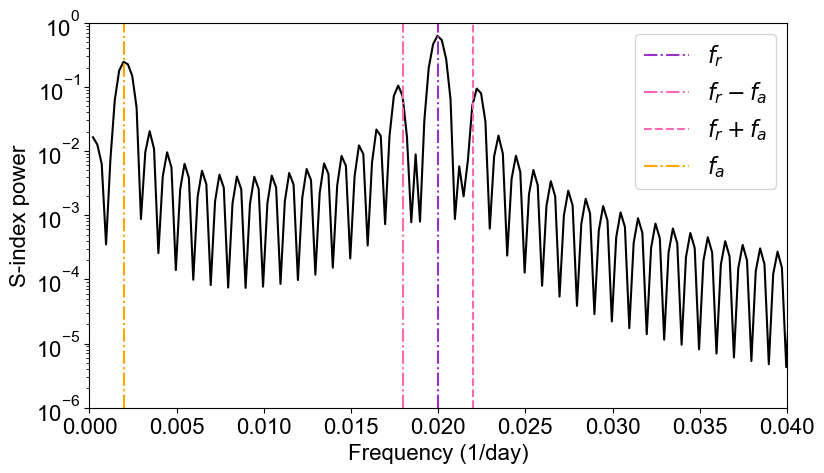

In [8]:
plt.figure(figsize=(9,5))
plt.semilogy(fgrid, modulated_signal2_pow, color='k')
plt.ylabel('S-index power')
plt.xlabel('Frequency (1/day)')
plt.axvline(f_rot, color='darkorchid', ls='-.', label=r"$f_r$")
plt.axvline(f_rot - f_activity, color='hotpink', ls='-.', label=r"$f_r - f_a$")
plt.axvline(f_rot + f_activity, color='hotpink', ls='--', label=r"$f_r + f_a$")
plt.axvline(f_activity, color='orange', ls='-.', label=r"$f_a$")
plt.legend(loc='best')
plt.xlim([0,0.04])
plt.ylim([1e-6, 1])

### Look at a real Mt. Wilson dataset with a possible modulated signal: <a href="http://simbad.u-strasbg.fr/simbad/sim-id?Ident=HD+97334&submit=submit+id">HD 97334</a>

I'm sending you a .zip file containing the entire set of Mt. Wilson observations. Here we use the <tt>pandas</tt> package to read a file containing a single star's observations into a data frame, which is python's version of a spreadsheet. You don't need to change any of the keywords in the call to <tt>pd.read_csv()</tt>. You can keep the 'names' keyword as is. Column names are:
<ul>
    <li>HD = star number in the Henry Draper catalog</li>
    <li>S cal = calibrated S-index measurement (these are the numbers you are going to use)</li>
    <li>JD-2444000 = Julian date - 2444000, which was a date in 1979. This is an astronomer's way of counting time. An increment in the ones place means 24 hours / one day have passed.</li>
    <li>weight = a number related to the signal-to-noise ratio of the observation, which we might at some point use to compute error bars</li>
    <li>KHR = ratio of calcium K-band to H-band emission</li>
    <li>Cvr = previous calibration of calcium index, not to be used here</li>
    <li>S inst = S-index on instrumental scale, uncalibrated</li>
    <li>Icode = instrument code</li>
    <li>Date = calendar date, e.g. 61583 = 6/15/1983</li>
    <li>UT time = universal time</li>
</ul>

Warning: both the telescope observations and the Lomb-Scargle periodograms will look a lot rattier than they do in my idealized example above.

In [9]:
# Change the path to wherever the HK_Project_v1995_NSO directory resides on your system. You shouldn't have to
# change anything after the first HK_Project_v1995_NSO directory
hd35296 = pd.read_csv('/Users/haydenatkinson/Downloads/HK_Project_v1995_NSO/35296.mgd', 
                       delim_whitespace=True, header=None, 
                       names=['HD', 'S cal', 'JD-2444000', 'weight', 'KHR', 'Cvr', 'S inst', 'Icode', 'Date', 'UT time'])
hd35296

,HD,S cal,JD-2444000,weight,KHR,Cvr,S inst,Icode,Date,UT time
0,35296,0.3710,-4607.20000,0.0,0.0000,0.0000,0.3231,A1YA,92466,80000
1,35296,0.3670,-4577.20000,0.0,0.0000,0.0000,0.3196,A1YA,102466,80000
2,35296,0.3301,-4513.20000,0.0,0.0000,0.0000,0.2875,A1YA,122766,80000
3,35296,0.3501,-4512.20000,0.0,0.0000,0.0000,0.3049,A1YA,122866,80000
4,35296,0.3406,-4484.20000,0.0,0.0000,0.0000,0.2966,A1YA,12567,80000
...,...,...,...,...,...,...,...,...,...,...
1874,35296,0.3390,5772.69727,15434.9,1.0172,1.0715,0.2754,C1YC,22495,44413
1875,35296,0.3289,5772.69873,13333.0,1.0338,1.1006,0.2672,C1YC,22495,44555
1876,35296,0.3081,5784.66602,13577.1,0.9810,1.1020,0.2522,C1YC,30895,35905
1877,35296,0.3157,5784.66699,14949.4,1.0271,1.0774,0.2584,C1YC,30895,40046


### Scatter plot of the S-index data

<AxesSubplot:xlabel='JD-2444000', ylabel='S cal'>

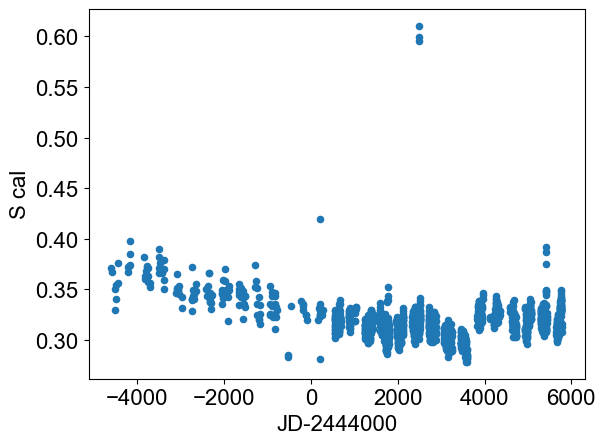

In [10]:
hd35296.plot.scatter('JD-2444000', 'S cal')

### Get rid of the outliers

You can see a few data points with huge S values, around 0.6. Either the star was flaring when those measurements were taken, or something went wrong with the observations. These "outliers" can bias our periodogram. Since we don't want our investigation of modulated rotation signals to be affected by either flares or bad measurements, let's cut those out. This operation is called "sigma clipping". We are going to get rid of data points that are more than three standard deviations or $3\sigma$ from the mean of the time series.

<AxesSubplot:title={'center':'Outliers removed'}, xlabel='JD-2444000', ylabel='S cal'>

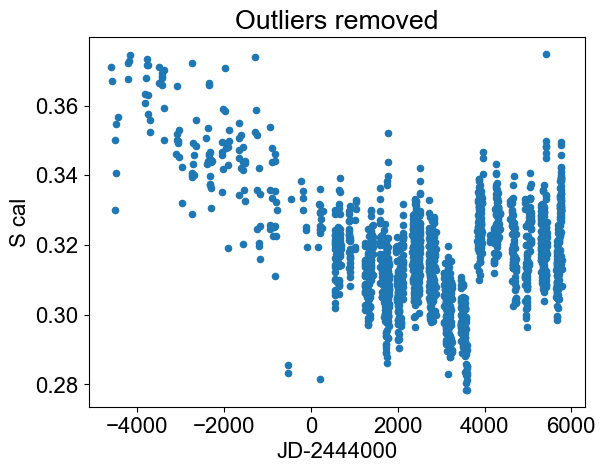

In [11]:
# mean() calculates the average of a column, while std() calculates its standard deviation
good_data = np.abs(hd35296['S cal'] - hd35296['S cal'].mean()) < 3*hd35296['S cal'].std()
hd35296 = hd35296[good_data]
hd35296.plot.scatter('JD-2444000', 'S cal', title='Outliers removed')

### Lomb-Scargle periodogram and false alarm levels

For my synthetic dataset, I computed my own frequency grid because I knew exactly which frequencies contained meaningful information. For real astronomical datasets in which the time interval between observations varies, it's not always clear what the frequency grid should be. Here we will use the <tt>LombScargle</tt> object's inbuilt gridding function. Later, as we start getting into more detailed analysis, we'll start to make our own frequency grids.

In [12]:
hd35296_LS = LombScargle(hd35296['JD-2444000'], hd35296['S cal']) # create Lomb-Scargle object
hd35296_f, hd35296_pow = hd35296_LS.autopower() # get frequency grid and power
hd35296_fals = hd35296_LS.false_alarm_level(faprobs)

#### Two plots: linear y-axis, logarithmic y-axis

In my research, I almost always use the semilog-y plot.

(3e-06, 0.35)

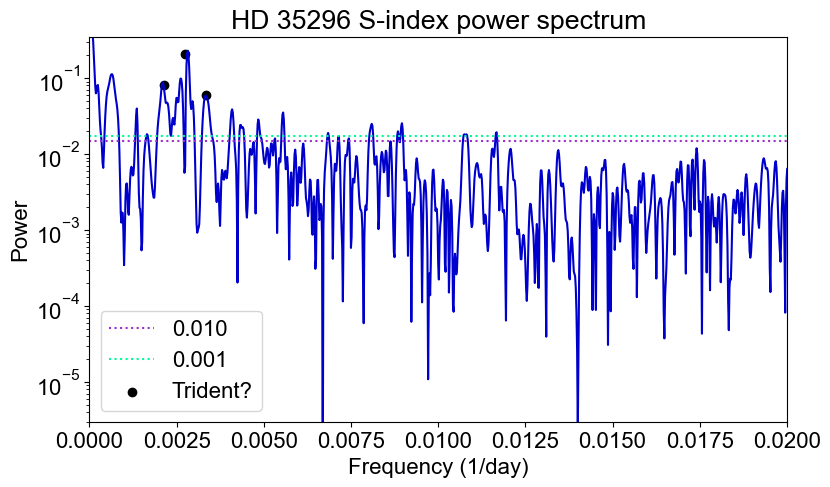

In [13]:
colors = ['darkorchid', 'mediumspringgreen', 'crimson']
plt.figure(figsize=(9,5))
plt.semilogy(hd35296_f, hd35296_pow, color='mediumblue')
for i in range(len(hd35296_fals)):
    plt.axhline(hd35296_fals[i], color=colors[i], ls=':', label=f"{faprobs[i]:.3f}")
plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title('HD 35296 S-index power spectrum')
plt.scatter([0.00215, 0.00275, 0.00335], [0.08, 0.21, 0.059], color='k', label='Trident?')
plt.legend(loc='best')
plt.xlim([0,0.02])
plt.ylim([3e-6, 0.35])

#### The three peaks are at frequencies 0.00215, 0.00275, and 0.00335 cycles/day. What if they come from a modulated rotation signal?

In that case, the rotation frequency would be 0.00275 cycles/day. The corresponding rotation period is 363.6 days. The sun's rotation period in an invariant frame is 27 days = 0.037 cycles/day, so it rotates much faster. Thus, the 363.6-day signal coming from HD 35296 probably does not come from rotation, unless the star is evolving into a giant. (The Mt. Wilson target stars were selected because they are mostly sunlike.)

The corresponding modulation frequency would be 0.0006 cycles/day, for an activity cycle period of about 1667 days or 4.6 years. That's a reasonable number for a sunlike star.

### Your job: search for modulated signals from other stars in the Mt. Wilson database


Look at the Lomb-Scargle periodograms of other S-index time series see if there's anything that looks like either a split peak or a trident. <strong>Look for peaks that are very close together.</strong>

To start, try input files 107213.mgd, 143761.mgd, 13421.mgd, 187013.mgd, 149661.mgd, 216385.mgd, 187691.mgd, 39587.mgd, 131156A.mgd, 212754.mgd, 124570.mgd, 159332.mgd, 207978.mgd, 22049.mgd, 9562.mgd, 45067.mgd, 07213.mgd. After you examine those, you can choose other stars to investigate. Note: some data files only have a few measurements. For meaningful results, make sure each data file you examine has at least 150 measurements.

The number in each file name is the star's HD catalog number. Use exactly the same <tt>pd.read_csv</tt> command that I have used to read the HD 35296 dataset; change only the file name. Then you can copy the syntax I used to make my Lomb-Scargle periodogram and plots.

Rule number one of astronomy: always look at the data! Just by looking with your eyes at a dataset that others before have only analyzed in batch, you might discover something interesting.

In [14]:
print(np.floor(3.1))

3.0


Maximum peak separation (maximum magnetic activity frequency): 0.002/day
Rotation frequency search interval: [0.02/day, 0.05/day]
Frequency resolution: 4.5e-05/day
Peak radius: 0.00015/day

Trident Found: 0.02 , 0.000315
Trident Found: 0.02 , 0.00036
Trident Found: 0.02 , 0.000405
Trident Found: 0.02 , 0.00045
Trident Found: 0.02 , 0.000495
Trident Found: 0.02 , 0.00054
Trident Found: 0.02 , 0.000585
Trident Found: 0.02 , 0.00063
Trident Found: 0.02 , 0.000675
Trident Found: 0.02 , 0.00072
Trident Found: 0.02 , 0.000765
Trident Found: 0.02 , 0.00081
Trident Found: 0.02 , 0.000855
Trident Found: 0.02 , 0.0009
Trident Found: 0.02 , 0.000945
Trident Found: 0.02 , 0.00099
Trident Found: 0.02 , 0.001035
Trident Found: 0.02 , 0.00108
Trident Found: 0.02 , 0.001125
Trident Found: 0.02 , 0.00117
Trident Found: 0.02 , 0.001215
Trident Found: 0.02 , 0.00126
Trident Found: 0.02 , 0.001305
Trident Found: 0.02 , 0.00135
Trident Found: 0.02 , 0.001395
Trident Found: 0.02 , 0.00144
Trident Found: 0.0

Trident Found: 0.020315 , 0.001935
Trident Found: 0.020315 , 0.00198
Trident Found: 0.02036 , 0.000315
Trident Found: 0.02036 , 0.00036
Trident Found: 0.02036 , 0.000405
Trident Found: 0.02036 , 0.00045
Trident Found: 0.02036 , 0.000495
Trident Found: 0.02036 , 0.00054
Trident Found: 0.02036 , 0.000585
Trident Found: 0.02036 , 0.00063
Trident Found: 0.02036 , 0.000675
Trident Found: 0.02036 , 0.00072
Trident Found: 0.02036 , 0.000765
Trident Found: 0.02036 , 0.00081
Trident Found: 0.02036 , 0.000855
Trident Found: 0.02036 , 0.0009
Trident Found: 0.02036 , 0.000945
Trident Found: 0.02036 , 0.00099
Trident Found: 0.02036 , 0.001035
Trident Found: 0.02036 , 0.00108
Trident Found: 0.02036 , 0.001125
Trident Found: 0.02036 , 0.00117
Trident Found: 0.02036 , 0.001215
Trident Found: 0.02036 , 0.00126
Trident Found: 0.02036 , 0.001305
Trident Found: 0.02036 , 0.00135
Trident Found: 0.02036 , 0.001395
Trident Found: 0.02036 , 0.00144
Trident Found: 0.02036 , 0.001485
Trident Found: 0.02036 , 0.

Trident Found: 0.020675 , 0.00153
Trident Found: 0.020675 , 0.001575
Trident Found: 0.020675 , 0.00162
Trident Found: 0.020675 , 0.001665
Trident Found: 0.020675 , 0.00171
Trident Found: 0.020675 , 0.001755
Trident Found: 0.020675 , 0.0018
Trident Found: 0.020675 , 0.001845
Trident Found: 0.020675 , 0.00189
Trident Found: 0.020675 , 0.001935
Trident Found: 0.020675 , 0.00198
Trident Found: 0.02072 , 0.000315
Trident Found: 0.02072 , 0.00036
Trident Found: 0.02072 , 0.000405
Trident Found: 0.02072 , 0.00045
Trident Found: 0.02072 , 0.000495
Trident Found: 0.02072 , 0.00054
Trident Found: 0.02072 , 0.000585
Trident Found: 0.02072 , 0.00063
Trident Found: 0.02072 , 0.000675
Trident Found: 0.02072 , 0.00072
Trident Found: 0.02072 , 0.000765
Trident Found: 0.02072 , 0.00081
Trident Found: 0.02072 , 0.000855
Trident Found: 0.02072 , 0.0009
Trident Found: 0.02072 , 0.000945
Trident Found: 0.02072 , 0.00099
Trident Found: 0.02072 , 0.001035
Trident Found: 0.02072 , 0.00108
Trident Found: 0.020

Trident Found: 0.021035 , 0.0009
Trident Found: 0.021035 , 0.000945
Trident Found: 0.021035 , 0.00099
Trident Found: 0.021035 , 0.001035
Trident Found: 0.021035 , 0.00108
Trident Found: 0.021035 , 0.001125
Trident Found: 0.021035 , 0.00117
Trident Found: 0.021035 , 0.001215
Trident Found: 0.021035 , 0.00126
Trident Found: 0.021035 , 0.001305
Trident Found: 0.021035 , 0.00135
Trident Found: 0.021035 , 0.001395
Trident Found: 0.021035 , 0.00144
Trident Found: 0.021035 , 0.001485
Trident Found: 0.021035 , 0.00153
Trident Found: 0.021035 , 0.001575
Trident Found: 0.021035 , 0.00162
Trident Found: 0.021035 , 0.001665
Trident Found: 0.021035 , 0.00171
Trident Found: 0.021035 , 0.001755
Trident Found: 0.021035 , 0.0018
Trident Found: 0.021035 , 0.001845
Trident Found: 0.021035 , 0.00189
Trident Found: 0.021035 , 0.001935
Trident Found: 0.021035 , 0.00198
Trident Found: 0.02108 , 0.000315
Trident Found: 0.02108 , 0.00036
Trident Found: 0.02108 , 0.000405
Trident Found: 0.02108 , 0.00045
Triden

Trident Found: 0.021395 , 0.00063
Trident Found: 0.021395 , 0.000675
Trident Found: 0.021395 , 0.00072
Trident Found: 0.021395 , 0.000765
Trident Found: 0.021395 , 0.00081
Trident Found: 0.021395 , 0.000855
Trident Found: 0.021395 , 0.0009
Trident Found: 0.021395 , 0.000945
Trident Found: 0.021395 , 0.00099
Trident Found: 0.021395 , 0.001035
Trident Found: 0.021395 , 0.00108
Trident Found: 0.021395 , 0.001125
Trident Found: 0.021395 , 0.00117
Trident Found: 0.021395 , 0.001215
Trident Found: 0.021395 , 0.00126
Trident Found: 0.021395 , 0.001305
Trident Found: 0.021395 , 0.00135
Trident Found: 0.021395 , 0.001395
Trident Found: 0.021395 , 0.00144
Trident Found: 0.021395 , 0.001485
Trident Found: 0.021395 , 0.00153
Trident Found: 0.021395 , 0.001575
Trident Found: 0.021395 , 0.00162
Trident Found: 0.021395 , 0.001665
Trident Found: 0.021395 , 0.00171
Trident Found: 0.021395 , 0.001755
Trident Found: 0.021395 , 0.0018
Trident Found: 0.021395 , 0.001845
Trident Found: 0.021395 , 0.00189
Tr

Trident Found: 0.02171 , 0.00171
Trident Found: 0.02171 , 0.001755
Trident Found: 0.02171 , 0.0018
Trident Found: 0.02171 , 0.001845
Trident Found: 0.02171 , 0.00189
Trident Found: 0.02171 , 0.001935
Trident Found: 0.02171 , 0.00198
Trident Found: 0.021755 , 0.000315
Trident Found: 0.021755 , 0.00036
Trident Found: 0.021755 , 0.000405
Trident Found: 0.021755 , 0.00045
Trident Found: 0.021755 , 0.000495
Trident Found: 0.021755 , 0.00054
Trident Found: 0.021755 , 0.000585
Trident Found: 0.021755 , 0.00063
Trident Found: 0.021755 , 0.000675
Trident Found: 0.021755 , 0.00072
Trident Found: 0.021755 , 0.000765
Trident Found: 0.021755 , 0.00081
Trident Found: 0.021755 , 0.000855
Trident Found: 0.021755 , 0.0009
Trident Found: 0.021755 , 0.000945
Trident Found: 0.021755 , 0.00099
Trident Found: 0.021755 , 0.001035
Trident Found: 0.021755 , 0.00108
Trident Found: 0.021755 , 0.001125
Trident Found: 0.021755 , 0.00117
Trident Found: 0.021755 , 0.001215
Trident Found: 0.021755 , 0.00126
Trident F

Trident Found: 0.022025 , 0.0018
Trident Found: 0.022025 , 0.001845
Trident Found: 0.022025 , 0.00189
Trident Found: 0.022025 , 0.001935
Trident Found: 0.022025 , 0.00198
Trident Found: 0.02207 , 0.000315
Trident Found: 0.02207 , 0.00036
Trident Found: 0.02207 , 0.000405
Trident Found: 0.02207 , 0.00045
Trident Found: 0.02207 , 0.000495
Trident Found: 0.02207 , 0.00054
Trident Found: 0.02207 , 0.000585
Trident Found: 0.02207 , 0.00063
Trident Found: 0.02207 , 0.000675
Trident Found: 0.02207 , 0.00072
Trident Found: 0.02207 , 0.000765
Trident Found: 0.02207 , 0.00081
Trident Found: 0.02207 , 0.000855
Trident Found: 0.02207 , 0.0009
Trident Found: 0.02207 , 0.000945
Trident Found: 0.02207 , 0.00099
Trident Found: 0.02207 , 0.001035
Trident Found: 0.02207 , 0.00108
Trident Found: 0.02207 , 0.001125
Trident Found: 0.02207 , 0.00117
Trident Found: 0.02207 , 0.001215
Trident Found: 0.02207 , 0.00126
Trident Found: 0.02207 , 0.001305
Trident Found: 0.02207 , 0.00135
Trident Found: 0.02207 , 0

Trident Found: 0.02234 , 0.001485
Trident Found: 0.02234 , 0.00153
Trident Found: 0.02234 , 0.001575
Trident Found: 0.02234 , 0.00162
Trident Found: 0.02234 , 0.001665
Trident Found: 0.02234 , 0.00171
Trident Found: 0.02234 , 0.001755
Trident Found: 0.02234 , 0.0018
Trident Found: 0.02234 , 0.001845
Trident Found: 0.02234 , 0.00189
Trident Found: 0.02234 , 0.001935
Trident Found: 0.02234 , 0.00198
Trident Found: 0.022385 , 0.000315
Trident Found: 0.022385 , 0.00036
Trident Found: 0.022385 , 0.000405
Trident Found: 0.022385 , 0.00045
Trident Found: 0.022385 , 0.000495
Trident Found: 0.022385 , 0.00054
Trident Found: 0.022385 , 0.000585
Trident Found: 0.022385 , 0.00063
Trident Found: 0.022385 , 0.000675
Trident Found: 0.022385 , 0.00072
Trident Found: 0.022385 , 0.000765
Trident Found: 0.022385 , 0.00081
Trident Found: 0.022385 , 0.000855
Trident Found: 0.022385 , 0.0009
Trident Found: 0.022385 , 0.000945
Trident Found: 0.022385 , 0.00099
Trident Found: 0.022385 , 0.001035
Trident Found

Trident Found: 0.0227 , 0.000495
Trident Found: 0.0227 , 0.00054
Trident Found: 0.0227 , 0.000585
Trident Found: 0.0227 , 0.00063
Trident Found: 0.0227 , 0.000675
Trident Found: 0.0227 , 0.00072
Trident Found: 0.0227 , 0.000765
Trident Found: 0.0227 , 0.00081
Trident Found: 0.0227 , 0.000855
Trident Found: 0.0227 , 0.0009
Trident Found: 0.0227 , 0.000945
Trident Found: 0.0227 , 0.00099
Trident Found: 0.0227 , 0.001035
Trident Found: 0.0227 , 0.00108
Trident Found: 0.0227 , 0.001125
Trident Found: 0.0227 , 0.00117
Trident Found: 0.0227 , 0.001215
Trident Found: 0.0227 , 0.00126
Trident Found: 0.0227 , 0.001305
Trident Found: 0.0227 , 0.00135
Trident Found: 0.0227 , 0.001395
Trident Found: 0.0227 , 0.00144
Trident Found: 0.0227 , 0.001485
Trident Found: 0.0227 , 0.00153
Trident Found: 0.0227 , 0.001575
Trident Found: 0.0227 , 0.00162
Trident Found: 0.0227 , 0.001665
Trident Found: 0.0227 , 0.00171
Trident Found: 0.0227 , 0.001755
Trident Found: 0.0227 , 0.0018
Trident Found: 0.0227 , 0.0

Trident Found: 0.02306 , 0.00036
Trident Found: 0.02306 , 0.000405
Trident Found: 0.02306 , 0.00045
Trident Found: 0.02306 , 0.000495
Trident Found: 0.02306 , 0.00054
Trident Found: 0.02306 , 0.000585
Trident Found: 0.02306 , 0.00063
Trident Found: 0.02306 , 0.000675
Trident Found: 0.02306 , 0.00072
Trident Found: 0.02306 , 0.000765
Trident Found: 0.02306 , 0.00081
Trident Found: 0.02306 , 0.000855
Trident Found: 0.02306 , 0.0009
Trident Found: 0.02306 , 0.000945
Trident Found: 0.02306 , 0.00099
Trident Found: 0.02306 , 0.001035
Trident Found: 0.02306 , 0.00108
Trident Found: 0.02306 , 0.001125
Trident Found: 0.02306 , 0.00117
Trident Found: 0.02306 , 0.001215
Trident Found: 0.02306 , 0.00126
Trident Found: 0.02306 , 0.001305
Trident Found: 0.02306 , 0.00135
Trident Found: 0.02306 , 0.001395
Trident Found: 0.02306 , 0.00144
Trident Found: 0.02306 , 0.001485
Trident Found: 0.02306 , 0.00153
Trident Found: 0.02306 , 0.001575
Trident Found: 0.02306 , 0.00162
Trident Found: 0.02306 , 0.001

Trident Found: 0.023375 , 0.000945
Trident Found: 0.023375 , 0.00099
Trident Found: 0.023375 , 0.001035
Trident Found: 0.023375 , 0.00108
Trident Found: 0.023375 , 0.001125
Trident Found: 0.023375 , 0.00117
Trident Found: 0.023375 , 0.001215
Trident Found: 0.023375 , 0.00126
Trident Found: 0.023375 , 0.001305
Trident Found: 0.023375 , 0.00135
Trident Found: 0.023375 , 0.001395
Trident Found: 0.023375 , 0.00144
Trident Found: 0.023375 , 0.001485
Trident Found: 0.023375 , 0.00153
Trident Found: 0.023375 , 0.001575
Trident Found: 0.023375 , 0.00162
Trident Found: 0.023375 , 0.001665
Trident Found: 0.023375 , 0.00171
Trident Found: 0.023375 , 0.001755
Trident Found: 0.023375 , 0.0018
Trident Found: 0.023375 , 0.001845
Trident Found: 0.023375 , 0.00189
Trident Found: 0.023375 , 0.001935
Trident Found: 0.023375 , 0.00198
Trident Found: 0.02342 , 0.000315
Trident Found: 0.02342 , 0.00036
Trident Found: 0.02342 , 0.000405
Trident Found: 0.02342 , 0.00045
Trident Found: 0.02342 , 0.000495
Tride

Trident Found: 0.02369 , 0.00036
Trident Found: 0.02369 , 0.000405
Trident Found: 0.02369 , 0.00045
Trident Found: 0.02369 , 0.000495
Trident Found: 0.02369 , 0.00054
Trident Found: 0.02369 , 0.000585
Trident Found: 0.02369 , 0.00063
Trident Found: 0.02369 , 0.000675
Trident Found: 0.02369 , 0.00072
Trident Found: 0.02369 , 0.000765
Trident Found: 0.02369 , 0.00081
Trident Found: 0.02369 , 0.000855
Trident Found: 0.02369 , 0.0009
Trident Found: 0.02369 , 0.000945
Trident Found: 0.02369 , 0.00099
Trident Found: 0.02369 , 0.001035
Trident Found: 0.02369 , 0.00108
Trident Found: 0.02369 , 0.001125
Trident Found: 0.02369 , 0.00117
Trident Found: 0.02369 , 0.001215
Trident Found: 0.02369 , 0.00126
Trident Found: 0.02369 , 0.001305
Trident Found: 0.02369 , 0.00135
Trident Found: 0.02369 , 0.001395
Trident Found: 0.02369 , 0.00144
Trident Found: 0.02369 , 0.001485
Trident Found: 0.02369 , 0.00153
Trident Found: 0.02369 , 0.001575
Trident Found: 0.02369 , 0.00162
Trident Found: 0.02369 , 0.001

Trident Found: 0.024005 , 0.001125
Trident Found: 0.024005 , 0.00117
Trident Found: 0.024005 , 0.001215
Trident Found: 0.024005 , 0.00126
Trident Found: 0.024005 , 0.001305
Trident Found: 0.024005 , 0.00135
Trident Found: 0.024005 , 0.001395
Trident Found: 0.024005 , 0.00144
Trident Found: 0.024005 , 0.001485
Trident Found: 0.024005 , 0.00153
Trident Found: 0.024005 , 0.001575
Trident Found: 0.024005 , 0.00162
Trident Found: 0.024005 , 0.001665
Trident Found: 0.024005 , 0.00171
Trident Found: 0.024005 , 0.001755
Trident Found: 0.024005 , 0.0018
Trident Found: 0.024005 , 0.001845
Trident Found: 0.024005 , 0.00189
Trident Found: 0.024005 , 0.001935
Trident Found: 0.024005 , 0.00198
Trident Found: 0.02405 , 0.000315
Trident Found: 0.02405 , 0.00036
Trident Found: 0.02405 , 0.000405
Trident Found: 0.02405 , 0.00045
Trident Found: 0.02405 , 0.000495
Trident Found: 0.02405 , 0.00054
Trident Found: 0.02405 , 0.000585
Trident Found: 0.02405 , 0.00063
Trident Found: 0.02405 , 0.000675
Trident F

Trident Found: 0.024365 , 0.00036
Trident Found: 0.024365 , 0.000405
Trident Found: 0.024365 , 0.00045
Trident Found: 0.024365 , 0.000495
Trident Found: 0.024365 , 0.00054
Trident Found: 0.024365 , 0.000585
Trident Found: 0.024365 , 0.00063
Trident Found: 0.024365 , 0.000675
Trident Found: 0.024365 , 0.00072
Trident Found: 0.024365 , 0.000765
Trident Found: 0.024365 , 0.00081
Trident Found: 0.024365 , 0.000855
Trident Found: 0.024365 , 0.0009
Trident Found: 0.024365 , 0.000945
Trident Found: 0.024365 , 0.00099
Trident Found: 0.024365 , 0.001035
Trident Found: 0.024365 , 0.00108
Trident Found: 0.024365 , 0.001125
Trident Found: 0.024365 , 0.00117
Trident Found: 0.024365 , 0.001215
Trident Found: 0.024365 , 0.00126
Trident Found: 0.024365 , 0.001305
Trident Found: 0.024365 , 0.00135
Trident Found: 0.024365 , 0.001395
Trident Found: 0.024365 , 0.00144
Trident Found: 0.024365 , 0.001485
Trident Found: 0.024365 , 0.00153
Trident Found: 0.024365 , 0.001575
Trident Found: 0.024365 , 0.00162
T

Trident Found: 0.02468 , 0.00054
Trident Found: 0.02468 , 0.000585
Trident Found: 0.02468 , 0.00063
Trident Found: 0.02468 , 0.000675
Trident Found: 0.02468 , 0.00072
Trident Found: 0.02468 , 0.000765
Trident Found: 0.02468 , 0.00081
Trident Found: 0.02468 , 0.000855
Trident Found: 0.02468 , 0.0009
Trident Found: 0.02468 , 0.000945
Trident Found: 0.02468 , 0.00099
Trident Found: 0.02468 , 0.001035
Trident Found: 0.02468 , 0.00108
Trident Found: 0.02468 , 0.001125
Trident Found: 0.02468 , 0.00117
Trident Found: 0.02468 , 0.001215
Trident Found: 0.02468 , 0.00126
Trident Found: 0.02468 , 0.001305
Trident Found: 0.02468 , 0.00135
Trident Found: 0.02468 , 0.001395
Trident Found: 0.02468 , 0.00144
Trident Found: 0.02468 , 0.001485
Trident Found: 0.02468 , 0.00153
Trident Found: 0.02468 , 0.001575
Trident Found: 0.02468 , 0.00162
Trident Found: 0.02468 , 0.001665
Trident Found: 0.02468 , 0.00171
Trident Found: 0.02468 , 0.001755
Trident Found: 0.02468 , 0.0018
Trident Found: 0.02468 , 0.0018

Trident Found: 0.024995 , 0.00054
Trident Found: 0.024995 , 0.000585
Trident Found: 0.024995 , 0.00063
Trident Found: 0.024995 , 0.000675
Trident Found: 0.024995 , 0.00072
Trident Found: 0.024995 , 0.000765
Trident Found: 0.024995 , 0.00081
Trident Found: 0.024995 , 0.000855
Trident Found: 0.024995 , 0.0009
Trident Found: 0.024995 , 0.000945
Trident Found: 0.024995 , 0.00099
Trident Found: 0.024995 , 0.001035
Trident Found: 0.024995 , 0.00108
Trident Found: 0.024995 , 0.001125
Trident Found: 0.024995 , 0.00117
Trident Found: 0.024995 , 0.001215
Trident Found: 0.024995 , 0.00126
Trident Found: 0.024995 , 0.001305
Trident Found: 0.024995 , 0.00135
Trident Found: 0.024995 , 0.001395
Trident Found: 0.024995 , 0.00144
Trident Found: 0.024995 , 0.001485
Trident Found: 0.024995 , 0.00153
Trident Found: 0.024995 , 0.001575
Trident Found: 0.024995 , 0.00162
Trident Found: 0.024995 , 0.001665
Trident Found: 0.024995 , 0.00171
Trident Found: 0.024995 , 0.001755
Trident Found: 0.024995 , 0.0018
Tr

Trident Found: 0.02531 , 0.00063
Trident Found: 0.02531 , 0.000675
Trident Found: 0.02531 , 0.00072
Trident Found: 0.02531 , 0.000765
Trident Found: 0.02531 , 0.00081
Trident Found: 0.02531 , 0.000855
Trident Found: 0.02531 , 0.0009
Trident Found: 0.02531 , 0.000945
Trident Found: 0.02531 , 0.00099
Trident Found: 0.02531 , 0.001035
Trident Found: 0.02531 , 0.00108
Trident Found: 0.02531 , 0.001125
Trident Found: 0.02531 , 0.00117
Trident Found: 0.02531 , 0.001215
Trident Found: 0.02531 , 0.00126
Trident Found: 0.02531 , 0.001305
Trident Found: 0.02531 , 0.00135
Trident Found: 0.02531 , 0.001395
Trident Found: 0.02531 , 0.00144
Trident Found: 0.02531 , 0.001485
Trident Found: 0.02531 , 0.00153
Trident Found: 0.02531 , 0.001575
Trident Found: 0.02531 , 0.00162
Trident Found: 0.02531 , 0.001665
Trident Found: 0.02531 , 0.00171
Trident Found: 0.02531 , 0.001755
Trident Found: 0.02531 , 0.0018
Trident Found: 0.02531 , 0.001845
Trident Found: 0.02531 , 0.00189
Trident Found: 0.02531 , 0.0019

Trident Found: 0.02558 , 0.001575
Trident Found: 0.02558 , 0.00162
Trident Found: 0.02558 , 0.001665
Trident Found: 0.02558 , 0.00171
Trident Found: 0.02558 , 0.001755
Trident Found: 0.02558 , 0.0018
Trident Found: 0.02558 , 0.001845
Trident Found: 0.02558 , 0.00189
Trident Found: 0.02558 , 0.001935
Trident Found: 0.02558 , 0.00198
Trident Found: 0.025625 , 0.000315
Trident Found: 0.025625 , 0.00036
Trident Found: 0.025625 , 0.000405
Trident Found: 0.025625 , 0.00045
Trident Found: 0.025625 , 0.000495
Trident Found: 0.025625 , 0.00054
Trident Found: 0.025625 , 0.000585
Trident Found: 0.025625 , 0.00063
Trident Found: 0.025625 , 0.000675
Trident Found: 0.025625 , 0.00072
Trident Found: 0.025625 , 0.000765
Trident Found: 0.025625 , 0.00081
Trident Found: 0.025625 , 0.000855
Trident Found: 0.025625 , 0.0009
Trident Found: 0.025625 , 0.000945
Trident Found: 0.025625 , 0.00099
Trident Found: 0.025625 , 0.001035
Trident Found: 0.025625 , 0.00108
Trident Found: 0.025625 , 0.001125
Trident Fou

Trident Found: 0.025895 , 0.00063
Trident Found: 0.025895 , 0.000675
Trident Found: 0.025895 , 0.00072
Trident Found: 0.025895 , 0.000765
Trident Found: 0.025895 , 0.00081
Trident Found: 0.025895 , 0.000855
Trident Found: 0.025895 , 0.0009
Trident Found: 0.025895 , 0.000945
Trident Found: 0.025895 , 0.00099
Trident Found: 0.025895 , 0.001035
Trident Found: 0.025895 , 0.00108
Trident Found: 0.025895 , 0.001125
Trident Found: 0.025895 , 0.00117
Trident Found: 0.025895 , 0.001215
Trident Found: 0.025895 , 0.00126
Trident Found: 0.025895 , 0.001305
Trident Found: 0.025895 , 0.00135
Trident Found: 0.025895 , 0.001395
Trident Found: 0.025895 , 0.00144
Trident Found: 0.025895 , 0.001485
Trident Found: 0.025895 , 0.00153
Trident Found: 0.025895 , 0.001575
Trident Found: 0.025895 , 0.00162
Trident Found: 0.025895 , 0.001665
Trident Found: 0.025895 , 0.00171
Trident Found: 0.025895 , 0.001755
Trident Found: 0.025895 , 0.0018
Trident Found: 0.025895 , 0.001845
Trident Found: 0.025895 , 0.00189
Tr

Trident Found: 0.02621 , 0.00108
Trident Found: 0.02621 , 0.001125
Trident Found: 0.02621 , 0.00117
Trident Found: 0.02621 , 0.001215
Trident Found: 0.02621 , 0.00126
Trident Found: 0.02621 , 0.001305
Trident Found: 0.02621 , 0.00135
Trident Found: 0.02621 , 0.001395
Trident Found: 0.02621 , 0.00144
Trident Found: 0.02621 , 0.001485
Trident Found: 0.02621 , 0.00153
Trident Found: 0.02621 , 0.001575
Trident Found: 0.02621 , 0.00162
Trident Found: 0.02621 , 0.001665
Trident Found: 0.02621 , 0.00171
Trident Found: 0.02621 , 0.001755
Trident Found: 0.02621 , 0.0018
Trident Found: 0.02621 , 0.001845
Trident Found: 0.02621 , 0.00189
Trident Found: 0.02621 , 0.001935
Trident Found: 0.02621 , 0.00198
Trident Found: 0.026255 , 0.000315
Trident Found: 0.026255 , 0.00036
Trident Found: 0.026255 , 0.000405
Trident Found: 0.026255 , 0.00045
Trident Found: 0.026255 , 0.000495
Trident Found: 0.026255 , 0.00054
Trident Found: 0.026255 , 0.000585
Trident Found: 0.026255 , 0.00063
Trident Found: 0.02625

Trident Found: 0.026525 , 0.00054
Trident Found: 0.026525 , 0.000585
Trident Found: 0.026525 , 0.00063
Trident Found: 0.026525 , 0.000675
Trident Found: 0.026525 , 0.00072
Trident Found: 0.026525 , 0.000765
Trident Found: 0.026525 , 0.00081
Trident Found: 0.026525 , 0.000855
Trident Found: 0.026525 , 0.0009
Trident Found: 0.026525 , 0.000945
Trident Found: 0.026525 , 0.00099
Trident Found: 0.026525 , 0.001035
Trident Found: 0.026525 , 0.00108
Trident Found: 0.026525 , 0.001125
Trident Found: 0.026525 , 0.00117
Trident Found: 0.026525 , 0.001215
Trident Found: 0.026525 , 0.00126
Trident Found: 0.026525 , 0.001305
Trident Found: 0.026525 , 0.00135
Trident Found: 0.026525 , 0.001395
Trident Found: 0.026525 , 0.00144
Trident Found: 0.026525 , 0.001485
Trident Found: 0.026525 , 0.00153
Trident Found: 0.026525 , 0.001575
Trident Found: 0.026525 , 0.00162
Trident Found: 0.026525 , 0.001665
Trident Found: 0.026525 , 0.00171
Trident Found: 0.026525 , 0.001755
Trident Found: 0.026525 , 0.0018
Tr

Trident Found: 0.026795 , 0.00162
Trident Found: 0.026795 , 0.001665
Trident Found: 0.026795 , 0.00171
Trident Found: 0.026795 , 0.001755
Trident Found: 0.026795 , 0.0018
Trident Found: 0.026795 , 0.001845
Trident Found: 0.026795 , 0.00189
Trident Found: 0.026795 , 0.001935
Trident Found: 0.026795 , 0.00198
Trident Found: 0.02684 , 0.000315
Trident Found: 0.02684 , 0.00036
Trident Found: 0.02684 , 0.000405
Trident Found: 0.02684 , 0.00045
Trident Found: 0.02684 , 0.000495
Trident Found: 0.02684 , 0.00054
Trident Found: 0.02684 , 0.000585
Trident Found: 0.02684 , 0.00063
Trident Found: 0.02684 , 0.000675
Trident Found: 0.02684 , 0.00072
Trident Found: 0.02684 , 0.000765
Trident Found: 0.02684 , 0.00081
Trident Found: 0.02684 , 0.000855
Trident Found: 0.02684 , 0.0009
Trident Found: 0.02684 , 0.000945
Trident Found: 0.02684 , 0.00099
Trident Found: 0.02684 , 0.001035
Trident Found: 0.02684 , 0.00108
Trident Found: 0.02684 , 0.001125
Trident Found: 0.02684 , 0.00117
Trident Found: 0.02684

Trident Found: 0.02711 , 0.000675
Trident Found: 0.02711 , 0.00072
Trident Found: 0.02711 , 0.000765
Trident Found: 0.02711 , 0.00081
Trident Found: 0.02711 , 0.000855
Trident Found: 0.02711 , 0.0009
Trident Found: 0.02711 , 0.000945
Trident Found: 0.02711 , 0.00099
Trident Found: 0.02711 , 0.001035
Trident Found: 0.02711 , 0.00108
Trident Found: 0.02711 , 0.001125
Trident Found: 0.02711 , 0.00117
Trident Found: 0.02711 , 0.001215
Trident Found: 0.02711 , 0.00126
Trident Found: 0.02711 , 0.001305
Trident Found: 0.02711 , 0.00135
Trident Found: 0.02711 , 0.001395
Trident Found: 0.02711 , 0.00144
Trident Found: 0.02711 , 0.001485
Trident Found: 0.02711 , 0.00153
Trident Found: 0.02711 , 0.001575
Trident Found: 0.02711 , 0.00162
Trident Found: 0.02711 , 0.001665
Trident Found: 0.02711 , 0.00171
Trident Found: 0.02711 , 0.001755
Trident Found: 0.02711 , 0.0018
Trident Found: 0.02711 , 0.001845
Trident Found: 0.02711 , 0.00189
Trident Found: 0.02711 , 0.001935
Trident Found: 0.02711 , 0.001

Trident Found: 0.02738 , 0.00171
Trident Found: 0.02738 , 0.001755
Trident Found: 0.02738 , 0.0018
Trident Found: 0.02738 , 0.001845
Trident Found: 0.02738 , 0.00189
Trident Found: 0.02738 , 0.001935
Trident Found: 0.02738 , 0.00198
Trident Found: 0.027425 , 0.000315
Trident Found: 0.027425 , 0.00036
Trident Found: 0.027425 , 0.000405
Trident Found: 0.027425 , 0.00045
Trident Found: 0.027425 , 0.000495
Trident Found: 0.027425 , 0.00054
Trident Found: 0.027425 , 0.000585
Trident Found: 0.027425 , 0.00063
Trident Found: 0.027425 , 0.000675
Trident Found: 0.027425 , 0.00072
Trident Found: 0.027425 , 0.000765
Trident Found: 0.027425 , 0.00081
Trident Found: 0.027425 , 0.000855
Trident Found: 0.027425 , 0.0009
Trident Found: 0.027425 , 0.000945
Trident Found: 0.027425 , 0.00099
Trident Found: 0.027425 , 0.001035
Trident Found: 0.027425 , 0.00108
Trident Found: 0.027425 , 0.001125
Trident Found: 0.027425 , 0.00117
Trident Found: 0.027425 , 0.001215
Trident Found: 0.027425 , 0.00126
Trident F

Trident Found: 0.027695 , 0.001395
Trident Found: 0.027695 , 0.00144
Trident Found: 0.027695 , 0.001485
Trident Found: 0.027695 , 0.00153
Trident Found: 0.027695 , 0.001575
Trident Found: 0.027695 , 0.00162
Trident Found: 0.027695 , 0.001665
Trident Found: 0.027695 , 0.00171
Trident Found: 0.027695 , 0.001755
Trident Found: 0.027695 , 0.0018
Trident Found: 0.027695 , 0.001845
Trident Found: 0.027695 , 0.00189
Trident Found: 0.027695 , 0.001935
Trident Found: 0.027695 , 0.00198
Trident Found: 0.02774 , 0.000315
Trident Found: 0.02774 , 0.00036
Trident Found: 0.02774 , 0.000405
Trident Found: 0.02774 , 0.00045
Trident Found: 0.02774 , 0.000495
Trident Found: 0.02774 , 0.00054
Trident Found: 0.02774 , 0.000585
Trident Found: 0.02774 , 0.00063
Trident Found: 0.02774 , 0.000675
Trident Found: 0.02774 , 0.00072
Trident Found: 0.02774 , 0.000765
Trident Found: 0.02774 , 0.00081
Trident Found: 0.02774 , 0.000855
Trident Found: 0.02774 , 0.0009
Trident Found: 0.02774 , 0.000945
Trident Found: 0

Trident Found: 0.028055 , 0.000495
Trident Found: 0.028055 , 0.00054
Trident Found: 0.028055 , 0.000585
Trident Found: 0.028055 , 0.00063
Trident Found: 0.028055 , 0.000675
Trident Found: 0.028055 , 0.00072
Trident Found: 0.028055 , 0.000765
Trident Found: 0.028055 , 0.00081
Trident Found: 0.028055 , 0.000855
Trident Found: 0.028055 , 0.0009
Trident Found: 0.028055 , 0.000945
Trident Found: 0.028055 , 0.00099
Trident Found: 0.028055 , 0.001035
Trident Found: 0.028055 , 0.00108
Trident Found: 0.028055 , 0.001125
Trident Found: 0.028055 , 0.00117
Trident Found: 0.028055 , 0.001215
Trident Found: 0.028055 , 0.00126
Trident Found: 0.028055 , 0.001305
Trident Found: 0.028055 , 0.00135
Trident Found: 0.028055 , 0.001395
Trident Found: 0.028055 , 0.00144
Trident Found: 0.028055 , 0.001485
Trident Found: 0.028055 , 0.00153
Trident Found: 0.028055 , 0.001575
Trident Found: 0.028055 , 0.00162
Trident Found: 0.028055 , 0.001665
Trident Found: 0.028055 , 0.00171
Trident Found: 0.028055 , 0.001755


Trident Found: 0.028325 , 0.001215
Trident Found: 0.028325 , 0.00126
Trident Found: 0.028325 , 0.001305
Trident Found: 0.028325 , 0.00135
Trident Found: 0.028325 , 0.001395
Trident Found: 0.028325 , 0.00144
Trident Found: 0.028325 , 0.001485
Trident Found: 0.028325 , 0.00153
Trident Found: 0.028325 , 0.001575
Trident Found: 0.028325 , 0.00162
Trident Found: 0.028325 , 0.001665
Trident Found: 0.028325 , 0.00171
Trident Found: 0.028325 , 0.001755
Trident Found: 0.028325 , 0.0018
Trident Found: 0.028325 , 0.001845
Trident Found: 0.028325 , 0.00189
Trident Found: 0.028325 , 0.001935
Trident Found: 0.028325 , 0.00198
Trident Found: 0.02837 , 0.000315
Trident Found: 0.02837 , 0.00036
Trident Found: 0.02837 , 0.000405
Trident Found: 0.02837 , 0.00045
Trident Found: 0.02837 , 0.000495
Trident Found: 0.02837 , 0.00054
Trident Found: 0.02837 , 0.000585
Trident Found: 0.02837 , 0.00063
Trident Found: 0.02837 , 0.000675
Trident Found: 0.02837 , 0.00072
Trident Found: 0.02837 , 0.000765
Trident Fou

Trident Found: 0.02864 , 0.00117
Trident Found: 0.02864 , 0.001215
Trident Found: 0.02864 , 0.00126
Trident Found: 0.02864 , 0.001305
Trident Found: 0.02864 , 0.00135
Trident Found: 0.02864 , 0.001395
Trident Found: 0.02864 , 0.00144
Trident Found: 0.02864 , 0.001485
Trident Found: 0.02864 , 0.00153
Trident Found: 0.02864 , 0.001575
Trident Found: 0.02864 , 0.00162
Trident Found: 0.02864 , 0.001665
Trident Found: 0.02864 , 0.00171
Trident Found: 0.02864 , 0.001755
Trident Found: 0.02864 , 0.0018
Trident Found: 0.02864 , 0.001845
Trident Found: 0.02864 , 0.00189
Trident Found: 0.02864 , 0.001935
Trident Found: 0.02864 , 0.00198
Trident Found: 0.028685 , 0.000315
Trident Found: 0.028685 , 0.00036
Trident Found: 0.028685 , 0.000405
Trident Found: 0.028685 , 0.00045
Trident Found: 0.028685 , 0.000495
Trident Found: 0.028685 , 0.00054
Trident Found: 0.028685 , 0.000585
Trident Found: 0.028685 , 0.00063
Trident Found: 0.028685 , 0.000675
Trident Found: 0.028685 , 0.00072
Trident Found: 0.028

Trident Found: 0.028955 , 0.00162
Trident Found: 0.028955 , 0.001665
Trident Found: 0.028955 , 0.00171
Trident Found: 0.028955 , 0.001755
Trident Found: 0.028955 , 0.0018
Trident Found: 0.028955 , 0.001845
Trident Found: 0.028955 , 0.00189
Trident Found: 0.028955 , 0.001935
Trident Found: 0.028955 , 0.00198
Trident Found: 0.029 , 0.000315
Trident Found: 0.029 , 0.00036
Trident Found: 0.029 , 0.000405
Trident Found: 0.029 , 0.00045
Trident Found: 0.029 , 0.000495
Trident Found: 0.029 , 0.00054
Trident Found: 0.029 , 0.000585
Trident Found: 0.029 , 0.00063
Trident Found: 0.029 , 0.000675
Trident Found: 0.029 , 0.00072
Trident Found: 0.029 , 0.000765
Trident Found: 0.029 , 0.00081
Trident Found: 0.029 , 0.000855
Trident Found: 0.029 , 0.0009
Trident Found: 0.029 , 0.000945
Trident Found: 0.029 , 0.00099
Trident Found: 0.029 , 0.001035
Trident Found: 0.029 , 0.00108
Trident Found: 0.029 , 0.001125
Trident Found: 0.029 , 0.00117
Trident Found: 0.029 , 0.001215
Trident Found: 0.029 , 0.00126

Trident Found: 0.029315 , 0.00081
Trident Found: 0.029315 , 0.000855
Trident Found: 0.029315 , 0.0009
Trident Found: 0.029315 , 0.000945
Trident Found: 0.029315 , 0.00099
Trident Found: 0.029315 , 0.001035
Trident Found: 0.029315 , 0.00108
Trident Found: 0.029315 , 0.001125
Trident Found: 0.029315 , 0.00117
Trident Found: 0.029315 , 0.001215
Trident Found: 0.029315 , 0.00126
Trident Found: 0.029315 , 0.001305
Trident Found: 0.029315 , 0.00135
Trident Found: 0.029315 , 0.001395
Trident Found: 0.029315 , 0.00144
Trident Found: 0.029315 , 0.001485
Trident Found: 0.029315 , 0.00153
Trident Found: 0.029315 , 0.001575
Trident Found: 0.029315 , 0.00162
Trident Found: 0.029315 , 0.001665
Trident Found: 0.029315 , 0.00171
Trident Found: 0.029315 , 0.001755
Trident Found: 0.029315 , 0.0018
Trident Found: 0.029315 , 0.001845
Trident Found: 0.029315 , 0.00189
Trident Found: 0.029315 , 0.001935
Trident Found: 0.029315 , 0.00198
Trident Found: 0.02936 , 0.000315
Trident Found: 0.02936 , 0.00036
Trid

Trident Found: 0.02963 , 0.00117
Trident Found: 0.02963 , 0.001215
Trident Found: 0.02963 , 0.00126
Trident Found: 0.02963 , 0.001305
Trident Found: 0.02963 , 0.00135
Trident Found: 0.02963 , 0.001395
Trident Found: 0.02963 , 0.00144
Trident Found: 0.02963 , 0.001485
Trident Found: 0.02963 , 0.00153
Trident Found: 0.02963 , 0.001575
Trident Found: 0.02963 , 0.00162
Trident Found: 0.02963 , 0.001665
Trident Found: 0.02963 , 0.00171
Trident Found: 0.02963 , 0.001755
Trident Found: 0.02963 , 0.0018
Trident Found: 0.02963 , 0.001845
Trident Found: 0.02963 , 0.00189
Trident Found: 0.02963 , 0.001935
Trident Found: 0.02963 , 0.00198
Trident Found: 0.029675 , 0.000315
Trident Found: 0.029675 , 0.00036
Trident Found: 0.029675 , 0.000405
Trident Found: 0.029675 , 0.00045
Trident Found: 0.029675 , 0.000495
Trident Found: 0.029675 , 0.00054
Trident Found: 0.029675 , 0.000585
Trident Found: 0.029675 , 0.00063
Trident Found: 0.029675 , 0.000675
Trident Found: 0.029675 , 0.00072
Trident Found: 0.029

Trident Found: 0.029945 , 0.00198
Trident Found: 0.02999 , 0.000315
Trident Found: 0.02999 , 0.00036
Trident Found: 0.02999 , 0.000405
Trident Found: 0.02999 , 0.00045
Trident Found: 0.02999 , 0.000495
Trident Found: 0.02999 , 0.00054
Trident Found: 0.02999 , 0.000585
Trident Found: 0.02999 , 0.00063
Trident Found: 0.02999 , 0.000675
Trident Found: 0.02999 , 0.00072
Trident Found: 0.02999 , 0.000765
Trident Found: 0.02999 , 0.00081
Trident Found: 0.02999 , 0.000855
Trident Found: 0.02999 , 0.0009
Trident Found: 0.02999 , 0.000945
Trident Found: 0.02999 , 0.00099
Trident Found: 0.02999 , 0.001035
Trident Found: 0.02999 , 0.00108
Trident Found: 0.02999 , 0.001125
Trident Found: 0.02999 , 0.00117
Trident Found: 0.02999 , 0.001215
Trident Found: 0.02999 , 0.00126
Trident Found: 0.02999 , 0.001305
Trident Found: 0.02999 , 0.00135
Trident Found: 0.02999 , 0.001395
Trident Found: 0.02999 , 0.00144
Trident Found: 0.02999 , 0.001485
Trident Found: 0.02999 , 0.00153
Trident Found: 0.02999 , 0.00

Trident Found: 0.03026 , 0.0018
Trident Found: 0.03026 , 0.001845
Trident Found: 0.03026 , 0.00189
Trident Found: 0.03026 , 0.001935
Trident Found: 0.03026 , 0.00198
Trident Found: 0.030305 , 0.000315
Trident Found: 0.030305 , 0.00036
Trident Found: 0.030305 , 0.000405
Trident Found: 0.030305 , 0.00045
Trident Found: 0.030305 , 0.000495
Trident Found: 0.030305 , 0.00054
Trident Found: 0.030305 , 0.000585
Trident Found: 0.030305 , 0.00063
Trident Found: 0.030305 , 0.000675
Trident Found: 0.030305 , 0.00072
Trident Found: 0.030305 , 0.000765
Trident Found: 0.030305 , 0.00081
Trident Found: 0.030305 , 0.000855
Trident Found: 0.030305 , 0.0009
Trident Found: 0.030305 , 0.000945
Trident Found: 0.030305 , 0.00099
Trident Found: 0.030305 , 0.001035
Trident Found: 0.030305 , 0.00108
Trident Found: 0.030305 , 0.001125
Trident Found: 0.030305 , 0.00117
Trident Found: 0.030305 , 0.001215
Trident Found: 0.030305 , 0.00126
Trident Found: 0.030305 , 0.001305
Trident Found: 0.030305 , 0.00135
Trident

Trident Found: 0.030575 , 0.001395
Trident Found: 0.030575 , 0.00144
Trident Found: 0.030575 , 0.001485
Trident Found: 0.030575 , 0.00153
Trident Found: 0.030575 , 0.001575
Trident Found: 0.030575 , 0.00162
Trident Found: 0.030575 , 0.001665
Trident Found: 0.030575 , 0.00171
Trident Found: 0.030575 , 0.001755
Trident Found: 0.030575 , 0.0018
Trident Found: 0.030575 , 0.001845
Trident Found: 0.030575 , 0.00189
Trident Found: 0.030575 , 0.001935
Trident Found: 0.030575 , 0.00198
Trident Found: 0.03062 , 0.000315
Trident Found: 0.03062 , 0.00036
Trident Found: 0.03062 , 0.000405
Trident Found: 0.03062 , 0.00045
Trident Found: 0.03062 , 0.000495
Trident Found: 0.03062 , 0.00054
Trident Found: 0.03062 , 0.000585
Trident Found: 0.03062 , 0.00063
Trident Found: 0.03062 , 0.000675
Trident Found: 0.03062 , 0.00072
Trident Found: 0.03062 , 0.000765
Trident Found: 0.03062 , 0.00081
Trident Found: 0.03062 , 0.000855
Trident Found: 0.03062 , 0.0009
Trident Found: 0.03062 , 0.000945
Trident Found: 0

Trident Found: 0.030935 , 0.001035
Trident Found: 0.030935 , 0.00108
Trident Found: 0.030935 , 0.001125
Trident Found: 0.030935 , 0.00117
Trident Found: 0.030935 , 0.001215
Trident Found: 0.030935 , 0.00126
Trident Found: 0.030935 , 0.001305
Trident Found: 0.030935 , 0.00135
Trident Found: 0.030935 , 0.001395
Trident Found: 0.030935 , 0.00144
Trident Found: 0.030935 , 0.001485
Trident Found: 0.030935 , 0.00153
Trident Found: 0.030935 , 0.001575
Trident Found: 0.030935 , 0.00162
Trident Found: 0.030935 , 0.001665
Trident Found: 0.030935 , 0.00171
Trident Found: 0.030935 , 0.001755
Trident Found: 0.030935 , 0.0018
Trident Found: 0.030935 , 0.001845
Trident Found: 0.030935 , 0.00189
Trident Found: 0.030935 , 0.001935
Trident Found: 0.030935 , 0.00198
Trident Found: 0.03098 , 0.000315
Trident Found: 0.03098 , 0.00036
Trident Found: 0.03098 , 0.000405
Trident Found: 0.03098 , 0.00045
Trident Found: 0.03098 , 0.000495
Trident Found: 0.03098 , 0.00054
Trident Found: 0.03098 , 0.000585
Trident

Trident Found: 0.03125 , 0.00063
Trident Found: 0.03125 , 0.000675
Trident Found: 0.03125 , 0.00072
Trident Found: 0.03125 , 0.000765
Trident Found: 0.03125 , 0.00081
Trident Found: 0.03125 , 0.000855
Trident Found: 0.03125 , 0.0009
Trident Found: 0.03125 , 0.000945
Trident Found: 0.03125 , 0.00099
Trident Found: 0.03125 , 0.001035
Trident Found: 0.03125 , 0.00108
Trident Found: 0.03125 , 0.001125
Trident Found: 0.03125 , 0.00117
Trident Found: 0.03125 , 0.001215
Trident Found: 0.03125 , 0.00126
Trident Found: 0.03125 , 0.001305
Trident Found: 0.03125 , 0.00135
Trident Found: 0.03125 , 0.001395
Trident Found: 0.03125 , 0.00144
Trident Found: 0.03125 , 0.001485
Trident Found: 0.03125 , 0.00153
Trident Found: 0.03125 , 0.001575
Trident Found: 0.03125 , 0.00162
Trident Found: 0.03125 , 0.001665
Trident Found: 0.03125 , 0.00171
Trident Found: 0.03125 , 0.001755
Trident Found: 0.03125 , 0.0018
Trident Found: 0.03125 , 0.001845
Trident Found: 0.03125 , 0.00189
Trident Found: 0.03125 , 0.0019

Trident Found: 0.031565 , 0.0009
Trident Found: 0.031565 , 0.000945
Trident Found: 0.031565 , 0.00099
Trident Found: 0.031565 , 0.001035
Trident Found: 0.031565 , 0.00108
Trident Found: 0.031565 , 0.001125
Trident Found: 0.031565 , 0.00117
Trident Found: 0.031565 , 0.001215
Trident Found: 0.031565 , 0.00126
Trident Found: 0.031565 , 0.001305
Trident Found: 0.031565 , 0.00135
Trident Found: 0.031565 , 0.001395
Trident Found: 0.031565 , 0.00144
Trident Found: 0.031565 , 0.001485
Trident Found: 0.031565 , 0.00153
Trident Found: 0.031565 , 0.001575
Trident Found: 0.031565 , 0.00162
Trident Found: 0.031565 , 0.001665
Trident Found: 0.031565 , 0.00171
Trident Found: 0.031565 , 0.001755
Trident Found: 0.031565 , 0.0018
Trident Found: 0.031565 , 0.001845
Trident Found: 0.031565 , 0.00189
Trident Found: 0.031565 , 0.001935
Trident Found: 0.031565 , 0.00198
Trident Found: 0.03161 , 0.000315
Trident Found: 0.03161 , 0.00036
Trident Found: 0.03161 , 0.000405
Trident Found: 0.03161 , 0.00045
Triden

Trident Found: 0.03188 , 0.001575
Trident Found: 0.03188 , 0.00162
Trident Found: 0.03188 , 0.001665
Trident Found: 0.03188 , 0.00171
Trident Found: 0.03188 , 0.001755
Trident Found: 0.03188 , 0.0018
Trident Found: 0.031925 , 0.000315
Trident Found: 0.031925 , 0.00036
Trident Found: 0.031925 , 0.000405
Trident Found: 0.031925 , 0.00045
Trident Found: 0.031925 , 0.000495
Trident Found: 0.031925 , 0.00054
Trident Found: 0.031925 , 0.000585
Trident Found: 0.031925 , 0.00063
Trident Found: 0.031925 , 0.000675
Trident Found: 0.031925 , 0.00072
Trident Found: 0.031925 , 0.000765
Trident Found: 0.031925 , 0.00081
Trident Found: 0.031925 , 0.000855
Trident Found: 0.031925 , 0.0009
Trident Found: 0.031925 , 0.000945
Trident Found: 0.031925 , 0.00099
Trident Found: 0.031925 , 0.001035
Trident Found: 0.031925 , 0.00108
Trident Found: 0.031925 , 0.001125
Trident Found: 0.031925 , 0.00117
Trident Found: 0.031925 , 0.001215
Trident Found: 0.031925 , 0.00126
Trident Found: 0.031925 , 0.001305
Trident

Trident Found: 0.032285 , 0.000585
Trident Found: 0.032285 , 0.00063
Trident Found: 0.032285 , 0.000675
Trident Found: 0.032285 , 0.00072
Trident Found: 0.032285 , 0.000765
Trident Found: 0.032285 , 0.00081
Trident Found: 0.032285 , 0.000855
Trident Found: 0.032285 , 0.0009
Trident Found: 0.032285 , 0.000945
Trident Found: 0.032285 , 0.00099
Trident Found: 0.032285 , 0.001035
Trident Found: 0.032285 , 0.00108
Trident Found: 0.032285 , 0.001125
Trident Found: 0.032285 , 0.00117
Trident Found: 0.032285 , 0.001215
Trident Found: 0.032285 , 0.00126
Trident Found: 0.032285 , 0.001305
Trident Found: 0.032285 , 0.00135
Trident Found: 0.032285 , 0.001395
Trident Found: 0.032285 , 0.001755
Trident Found: 0.032285 , 0.0018
Trident Found: 0.032285 , 0.001845
Trident Found: 0.032285 , 0.00189
Trident Found: 0.032285 , 0.001935
Trident Found: 0.032285 , 0.00198
Trident Found: 0.03233 , 0.000315
Trident Found: 0.03233 , 0.00036
Trident Found: 0.03233 , 0.000405
Trident Found: 0.03233 , 0.00045
Tride

Trident Found: 0.032645 , 0.00099
Trident Found: 0.032645 , 0.001035
Trident Found: 0.032645 , 0.001395
Trident Found: 0.032645 , 0.00144
Trident Found: 0.032645 , 0.001485
Trident Found: 0.032645 , 0.00153
Trident Found: 0.032645 , 0.001575
Trident Found: 0.032645 , 0.00162
Trident Found: 0.032645 , 0.001665
Trident Found: 0.032645 , 0.00171
Trident Found: 0.032645 , 0.001755
Trident Found: 0.032645 , 0.0018
Trident Found: 0.032645 , 0.001845
Trident Found: 0.032645 , 0.00189
Trident Found: 0.032645 , 0.001935
Trident Found: 0.032645 , 0.00198
Trident Found: 0.03269 , 0.000315
Trident Found: 0.03269 , 0.00036
Trident Found: 0.03269 , 0.000405
Trident Found: 0.03269 , 0.00045
Trident Found: 0.03269 , 0.000495
Trident Found: 0.03269 , 0.00054
Trident Found: 0.03269 , 0.000585
Trident Found: 0.03269 , 0.00063
Trident Found: 0.03269 , 0.000675
Trident Found: 0.03269 , 0.00072
Trident Found: 0.03269 , 0.000765
Trident Found: 0.03269 , 0.00081
Trident Found: 0.03269 , 0.000855
Trident Found

Trident Found: 0.03305 , 0.00108
Trident Found: 0.03305 , 0.001125
Trident Found: 0.03305 , 0.00117
Trident Found: 0.03305 , 0.001215
Trident Found: 0.03305 , 0.00126
Trident Found: 0.03305 , 0.001305
Trident Found: 0.03305 , 0.00135
Trident Found: 0.03305 , 0.001395
Trident Found: 0.03305 , 0.00144
Trident Found: 0.03305 , 0.001485
Trident Found: 0.03305 , 0.00153
Trident Found: 0.03305 , 0.001575
Trident Found: 0.03305 , 0.00162
Trident Found: 0.03305 , 0.001665
Trident Found: 0.03305 , 0.00171
Trident Found: 0.03305 , 0.001755
Trident Found: 0.03305 , 0.0018
Trident Found: 0.03305 , 0.001845
Trident Found: 0.03305 , 0.00189
Trident Found: 0.03305 , 0.001935
Trident Found: 0.03305 , 0.00198
Trident Found: 0.033095 , 0.000315
Trident Found: 0.033095 , 0.00036
Trident Found: 0.033095 , 0.000405
Trident Found: 0.033095 , 0.00045
Trident Found: 0.033095 , 0.000495
Trident Found: 0.033095 , 0.00054
Trident Found: 0.033095 , 0.000585
Trident Found: 0.033095 , 0.000945
Trident Found: 0.0330

Trident Found: 0.03341 , 0.00108
Trident Found: 0.03341 , 0.001125
Trident Found: 0.03341 , 0.00117
Trident Found: 0.03341 , 0.001215
Trident Found: 0.03341 , 0.00126
Trident Found: 0.03341 , 0.001305
Trident Found: 0.03341 , 0.00135
Trident Found: 0.03341 , 0.001395
Trident Found: 0.03341 , 0.00144
Trident Found: 0.03341 , 0.001485
Trident Found: 0.03341 , 0.00153
Trident Found: 0.03341 , 0.001575
Trident Found: 0.03341 , 0.00162
Trident Found: 0.03341 , 0.001665
Trident Found: 0.03341 , 0.00171
Trident Found: 0.03341 , 0.001755
Trident Found: 0.03341 , 0.0018
Trident Found: 0.03341 , 0.001845
Trident Found: 0.03341 , 0.00189
Trident Found: 0.03341 , 0.001935
Trident Found: 0.03341 , 0.00198
Trident Found: 0.033455 , 0.000585
Trident Found: 0.033455 , 0.00063
Trident Found: 0.033455 , 0.000675
Trident Found: 0.033455 , 0.00072
Trident Found: 0.033455 , 0.000765
Trident Found: 0.033455 , 0.00081
Trident Found: 0.033455 , 0.000855
Trident Found: 0.033455 , 0.0009
Trident Found: 0.033455

Trident Found: 0.03404 , 0.001485
Trident Found: 0.03404 , 0.00153
Trident Found: 0.03404 , 0.001575
Trident Found: 0.03404 , 0.00162
Trident Found: 0.03404 , 0.001665
Trident Found: 0.03404 , 0.00171
Trident Found: 0.03404 , 0.001755
Trident Found: 0.03404 , 0.0018
Trident Found: 0.03404 , 0.001845
Trident Found: 0.03404 , 0.00189
Trident Found: 0.03404 , 0.001935
Trident Found: 0.03404 , 0.00198
Trident Found: 0.034085 , 0.000405
Trident Found: 0.034085 , 0.00045
Trident Found: 0.034085 , 0.000495
Trident Found: 0.034085 , 0.00054
Trident Found: 0.034085 , 0.000585
Trident Found: 0.034085 , 0.00063
Trident Found: 0.034085 , 0.000675
Trident Found: 0.034085 , 0.00072
Trident Found: 0.034085 , 0.000765
Trident Found: 0.034085 , 0.00081
Trident Found: 0.034085 , 0.000855
Trident Found: 0.034085 , 0.0009
Trident Found: 0.034085 , 0.000945
Trident Found: 0.034085 , 0.00099
Trident Found: 0.034085 , 0.001035
Trident Found: 0.034085 , 0.00108
Trident Found: 0.034085 , 0.001125
Trident Found

Trident Found: 0.034445 , 0.000855
Trident Found: 0.034445 , 0.0009
Trident Found: 0.034445 , 0.000945
Trident Found: 0.034445 , 0.00099
Trident Found: 0.034445 , 0.001035
Trident Found: 0.034445 , 0.00108
Trident Found: 0.034445 , 0.001125
Trident Found: 0.034445 , 0.00117
Trident Found: 0.034445 , 0.001215
Trident Found: 0.034445 , 0.00126
Trident Found: 0.034445 , 0.001305
Trident Found: 0.034445 , 0.00135
Trident Found: 0.034445 , 0.001395
Trident Found: 0.034445 , 0.00144
Trident Found: 0.034445 , 0.001485
Trident Found: 0.034445 , 0.00153
Trident Found: 0.034445 , 0.001575
Trident Found: 0.034445 , 0.00162
Trident Found: 0.034445 , 0.001665
Trident Found: 0.034445 , 0.00171
Trident Found: 0.034445 , 0.001755
Trident Found: 0.034445 , 0.0018
Trident Found: 0.034445 , 0.001845
Trident Found: 0.034445 , 0.00189
Trident Found: 0.034445 , 0.001935
Trident Found: 0.034445 , 0.00198
Trident Found: 0.03449 , 0.000315
Trident Found: 0.03449 , 0.00036
Trident Found: 0.03449 , 0.000405
Trid

Trident Found: 0.034805 , 0.000765
Trident Found: 0.034805 , 0.001125
Trident Found: 0.034805 , 0.00117
Trident Found: 0.034805 , 0.001215
Trident Found: 0.034805 , 0.00126
Trident Found: 0.034805 , 0.001305
Trident Found: 0.034805 , 0.00135
Trident Found: 0.034805 , 0.001395
Trident Found: 0.034805 , 0.00144
Trident Found: 0.034805 , 0.001485
Trident Found: 0.034805 , 0.00153
Trident Found: 0.034805 , 0.001575
Trident Found: 0.034805 , 0.00162
Trident Found: 0.034805 , 0.001665
Trident Found: 0.034805 , 0.00171
Trident Found: 0.034805 , 0.001755
Trident Found: 0.034805 , 0.0018
Trident Found: 0.034805 , 0.001845
Trident Found: 0.034805 , 0.00189
Trident Found: 0.034805 , 0.001935
Trident Found: 0.034805 , 0.00198
Trident Found: 0.03485 , 0.000315
Trident Found: 0.03485 , 0.00036
Trident Found: 0.03485 , 0.000405
Trident Found: 0.03485 , 0.00045
Trident Found: 0.03485 , 0.000495
Trident Found: 0.03485 , 0.00054
Trident Found: 0.03485 , 0.000585
Trident Found: 0.03485 , 0.00063
Trident 

Trident Found: 0.03521 , 0.00081
Trident Found: 0.03521 , 0.000855
Trident Found: 0.03521 , 0.0009
Trident Found: 0.03521 , 0.000945
Trident Found: 0.03521 , 0.00099
Trident Found: 0.03521 , 0.001035
Trident Found: 0.03521 , 0.00108
Trident Found: 0.03521 , 0.001125
Trident Found: 0.03521 , 0.00117
Trident Found: 0.03521 , 0.00153
Trident Found: 0.03521 , 0.001575
Trident Found: 0.03521 , 0.00162
Trident Found: 0.03521 , 0.001665
Trident Found: 0.03521 , 0.00171
Trident Found: 0.03521 , 0.001755
Trident Found: 0.03521 , 0.0018
Trident Found: 0.03521 , 0.001845
Trident Found: 0.03521 , 0.00189
Trident Found: 0.03521 , 0.001935
Trident Found: 0.03521 , 0.00198
Trident Found: 0.035255 , 0.000315
Trident Found: 0.035255 , 0.00036
Trident Found: 0.035255 , 0.000405
Trident Found: 0.035255 , 0.00045
Trident Found: 0.035255 , 0.000495
Trident Found: 0.035255 , 0.00054
Trident Found: 0.035255 , 0.000585
Trident Found: 0.035255 , 0.00063
Trident Found: 0.035255 , 0.000675
Trident Found: 0.03525

Trident Found: 0.03557 , 0.00189
Trident Found: 0.03557 , 0.001935
Trident Found: 0.03557 , 0.00198
Trident Found: 0.035615 , 0.000315
Trident Found: 0.035615 , 0.00036
Trident Found: 0.035615 , 0.000405
Trident Found: 0.035615 , 0.00045
Trident Found: 0.035615 , 0.000495
Trident Found: 0.035615 , 0.00054
Trident Found: 0.035615 , 0.000585
Trident Found: 0.035615 , 0.00063
Trident Found: 0.035615 , 0.000675
Trident Found: 0.035615 , 0.00072
Trident Found: 0.035615 , 0.000765
Trident Found: 0.035615 , 0.00081
Trident Found: 0.035615 , 0.000855
Trident Found: 0.035615 , 0.0009
Trident Found: 0.035615 , 0.000945
Trident Found: 0.035615 , 0.00099
Trident Found: 0.035615 , 0.001035
Trident Found: 0.035615 , 0.00108
Trident Found: 0.035615 , 0.001125
Trident Found: 0.035615 , 0.00117
Trident Found: 0.035615 , 0.001215
Trident Found: 0.035615 , 0.00126
Trident Found: 0.035615 , 0.001305
Trident Found: 0.035615 , 0.00135
Trident Found: 0.035615 , 0.001395
Trident Found: 0.035615 , 0.00144
Trid

Trident Found: 0.03593 , 0.001665
Trident Found: 0.03593 , 0.00171
Trident Found: 0.03593 , 0.001755
Trident Found: 0.03593 , 0.0018
Trident Found: 0.03593 , 0.001845
Trident Found: 0.03593 , 0.00189
Trident Found: 0.035975 , 0.000315
Trident Found: 0.035975 , 0.00036
Trident Found: 0.035975 , 0.000405
Trident Found: 0.035975 , 0.00045
Trident Found: 0.035975 , 0.000495
Trident Found: 0.035975 , 0.00054
Trident Found: 0.035975 , 0.000585
Trident Found: 0.035975 , 0.00063
Trident Found: 0.035975 , 0.000675
Trident Found: 0.035975 , 0.00072
Trident Found: 0.035975 , 0.000765
Trident Found: 0.035975 , 0.00081
Trident Found: 0.035975 , 0.000855
Trident Found: 0.035975 , 0.0009
Trident Found: 0.035975 , 0.000945
Trident Found: 0.035975 , 0.00099
Trident Found: 0.035975 , 0.001035
Trident Found: 0.035975 , 0.00108
Trident Found: 0.035975 , 0.001125
Trident Found: 0.035975 , 0.00117
Trident Found: 0.035975 , 0.001215
Trident Found: 0.035975 , 0.00126
Trident Found: 0.035975 , 0.001305
Trident

Trident Found: 0.03629 , 0.00054
Trident Found: 0.03629 , 0.000585
Trident Found: 0.03629 , 0.00063
Trident Found: 0.03629 , 0.000675
Trident Found: 0.03629 , 0.00072
Trident Found: 0.03629 , 0.000765
Trident Found: 0.03629 , 0.00081
Trident Found: 0.03629 , 0.000855
Trident Found: 0.03629 , 0.0009
Trident Found: 0.03629 , 0.000945
Trident Found: 0.03629 , 0.00099
Trident Found: 0.03629 , 0.001035
Trident Found: 0.03629 , 0.00108
Trident Found: 0.03629 , 0.001125
Trident Found: 0.03629 , 0.00117
Trident Found: 0.03629 , 0.001215
Trident Found: 0.03629 , 0.00126
Trident Found: 0.03629 , 0.001305
Trident Found: 0.03629 , 0.00135
Trident Found: 0.03629 , 0.001395
Trident Found: 0.03629 , 0.00144
Trident Found: 0.03629 , 0.001485
Trident Found: 0.03629 , 0.00153
Trident Found: 0.03629 , 0.001575
Trident Found: 0.03629 , 0.00162
Trident Found: 0.03629 , 0.001665
Trident Found: 0.03629 , 0.00171
Trident Found: 0.03629 , 0.001755
Trident Found: 0.03629 , 0.0018
Trident Found: 0.03629 , 0.0018

Trident Found: 0.036605 , 0.00045
Trident Found: 0.036605 , 0.000495
Trident Found: 0.036605 , 0.00054
Trident Found: 0.036605 , 0.000585
Trident Found: 0.036605 , 0.00063
Trident Found: 0.036605 , 0.000675
Trident Found: 0.036605 , 0.00072
Trident Found: 0.036605 , 0.000765
Trident Found: 0.036605 , 0.00081
Trident Found: 0.036605 , 0.000855
Trident Found: 0.036605 , 0.0009
Trident Found: 0.036605 , 0.000945
Trident Found: 0.036605 , 0.00099
Trident Found: 0.036605 , 0.001035
Trident Found: 0.036605 , 0.00108
Trident Found: 0.036605 , 0.001125
Trident Found: 0.036605 , 0.00117
Trident Found: 0.036605 , 0.001215
Trident Found: 0.036605 , 0.00126
Trident Found: 0.036605 , 0.001305
Trident Found: 0.036605 , 0.00135
Trident Found: 0.036605 , 0.001395
Trident Found: 0.036605 , 0.00144
Trident Found: 0.036605 , 0.001485
Trident Found: 0.036605 , 0.00153
Trident Found: 0.036605 , 0.001575
Trident Found: 0.036605 , 0.00162
Trident Found: 0.036605 , 0.001665
Trident Found: 0.036605 , 0.00171
T

Trident Found: 0.036875 , 0.001485
Trident Found: 0.036875 , 0.00153
Trident Found: 0.036875 , 0.001575
Trident Found: 0.036875 , 0.00162
Trident Found: 0.036875 , 0.001665
Trident Found: 0.036875 , 0.00171
Trident Found: 0.036875 , 0.001755
Trident Found: 0.036875 , 0.0018
Trident Found: 0.036875 , 0.001845
Trident Found: 0.036875 , 0.00189
Trident Found: 0.036875 , 0.001935
Trident Found: 0.036875 , 0.00198
Trident Found: 0.03692 , 0.000315
Trident Found: 0.03692 , 0.00036
Trident Found: 0.03692 , 0.000405
Trident Found: 0.03692 , 0.00045
Trident Found: 0.03692 , 0.000495
Trident Found: 0.03692 , 0.00054
Trident Found: 0.03692 , 0.000585
Trident Found: 0.03692 , 0.00063
Trident Found: 0.03692 , 0.000675
Trident Found: 0.03692 , 0.00072
Trident Found: 0.03692 , 0.000765
Trident Found: 0.03692 , 0.00081
Trident Found: 0.03692 , 0.000855
Trident Found: 0.03692 , 0.0009
Trident Found: 0.03692 , 0.000945
Trident Found: 0.03692 , 0.00099
Trident Found: 0.03692 , 0.001035
Trident Found: 0.0

Trident Found: 0.03719 , 0.001395
Trident Found: 0.03719 , 0.00144
Trident Found: 0.03719 , 0.001485
Trident Found: 0.03719 , 0.00153
Trident Found: 0.03719 , 0.001575
Trident Found: 0.03719 , 0.00162
Trident Found: 0.03719 , 0.001665
Trident Found: 0.03719 , 0.00171
Trident Found: 0.03719 , 0.001755
Trident Found: 0.03719 , 0.0018
Trident Found: 0.03719 , 0.001845
Trident Found: 0.03719 , 0.00189
Trident Found: 0.03719 , 0.001935
Trident Found: 0.03719 , 0.00198
Trident Found: 0.037235 , 0.000315
Trident Found: 0.037235 , 0.00036
Trident Found: 0.037235 , 0.000405
Trident Found: 0.037235 , 0.00045
Trident Found: 0.037235 , 0.000495
Trident Found: 0.037235 , 0.00054
Trident Found: 0.037235 , 0.000585
Trident Found: 0.037235 , 0.00063
Trident Found: 0.037235 , 0.000675
Trident Found: 0.037235 , 0.00072
Trident Found: 0.037235 , 0.000765
Trident Found: 0.037235 , 0.00081
Trident Found: 0.037235 , 0.000855
Trident Found: 0.037235 , 0.0009
Trident Found: 0.037235 , 0.000945
Trident Found: 

Trident Found: 0.037505 , 0.00081
Trident Found: 0.037505 , 0.000855
Trident Found: 0.037505 , 0.0009
Trident Found: 0.037505 , 0.000945
Trident Found: 0.037505 , 0.00099
Trident Found: 0.037505 , 0.001035
Trident Found: 0.037505 , 0.00108
Trident Found: 0.037505 , 0.001125
Trident Found: 0.037505 , 0.00117
Trident Found: 0.037505 , 0.001215
Trident Found: 0.037505 , 0.00126
Trident Found: 0.037505 , 0.001305
Trident Found: 0.037505 , 0.00135
Trident Found: 0.037505 , 0.001395
Trident Found: 0.037505 , 0.00144
Trident Found: 0.037505 , 0.001485
Trident Found: 0.037505 , 0.00153
Trident Found: 0.037505 , 0.001575
Trident Found: 0.037505 , 0.00162
Trident Found: 0.037505 , 0.001665
Trident Found: 0.037505 , 0.00171
Trident Found: 0.037505 , 0.001755
Trident Found: 0.037505 , 0.0018
Trident Found: 0.037505 , 0.001845
Trident Found: 0.037505 , 0.00189
Trident Found: 0.037505 , 0.001935
Trident Found: 0.037505 , 0.00198
Trident Found: 0.03755 , 0.000315
Trident Found: 0.03755 , 0.00036
Trid

Trident Found: 0.03782 , 0.001125
Trident Found: 0.03782 , 0.00117
Trident Found: 0.03782 , 0.001215
Trident Found: 0.03782 , 0.00126
Trident Found: 0.03782 , 0.001305
Trident Found: 0.03782 , 0.00135
Trident Found: 0.03782 , 0.001395
Trident Found: 0.03782 , 0.00144
Trident Found: 0.03782 , 0.001485
Trident Found: 0.03782 , 0.00153
Trident Found: 0.03782 , 0.001575
Trident Found: 0.03782 , 0.00162
Trident Found: 0.03782 , 0.001665
Trident Found: 0.03782 , 0.00171
Trident Found: 0.03782 , 0.001755
Trident Found: 0.03782 , 0.0018
Trident Found: 0.03782 , 0.001845
Trident Found: 0.03782 , 0.00189
Trident Found: 0.03782 , 0.001935
Trident Found: 0.03782 , 0.00198
Trident Found: 0.037865 , 0.000315
Trident Found: 0.037865 , 0.00036
Trident Found: 0.037865 , 0.000405
Trident Found: 0.037865 , 0.00045
Trident Found: 0.037865 , 0.000495
Trident Found: 0.037865 , 0.00054
Trident Found: 0.037865 , 0.000585
Trident Found: 0.037865 , 0.00063
Trident Found: 0.037865 , 0.000675
Trident Found: 0.037

Trident Found: 0.038135 , 0.001035
Trident Found: 0.038135 , 0.00108
Trident Found: 0.038135 , 0.001125
Trident Found: 0.038135 , 0.00117
Trident Found: 0.038135 , 0.001215
Trident Found: 0.038135 , 0.00126
Trident Found: 0.038135 , 0.001305
Trident Found: 0.038135 , 0.00135
Trident Found: 0.038135 , 0.001395
Trident Found: 0.038135 , 0.00144
Trident Found: 0.038135 , 0.001485
Trident Found: 0.038135 , 0.00153
Trident Found: 0.038135 , 0.001575
Trident Found: 0.038135 , 0.00162
Trident Found: 0.038135 , 0.001665
Trident Found: 0.038135 , 0.00171
Trident Found: 0.038135 , 0.001755
Trident Found: 0.038135 , 0.0018
Trident Found: 0.038135 , 0.001845
Trident Found: 0.038135 , 0.00189
Trident Found: 0.038135 , 0.001935
Trident Found: 0.038135 , 0.00198
Trident Found: 0.03818 , 0.000315
Trident Found: 0.03818 , 0.00036
Trident Found: 0.03818 , 0.000405
Trident Found: 0.03818 , 0.00045
Trident Found: 0.03818 , 0.000495
Trident Found: 0.03818 , 0.00054
Trident Found: 0.03818 , 0.000585
Trident

Trident Found: 0.03845 , 0.000945
Trident Found: 0.03845 , 0.00099
Trident Found: 0.03845 , 0.001035
Trident Found: 0.03845 , 0.00108
Trident Found: 0.03845 , 0.001125
Trident Found: 0.03845 , 0.00117
Trident Found: 0.03845 , 0.001215
Trident Found: 0.03845 , 0.00126
Trident Found: 0.03845 , 0.001305
Trident Found: 0.03845 , 0.00135
Trident Found: 0.03845 , 0.001395
Trident Found: 0.03845 , 0.00144
Trident Found: 0.03845 , 0.001485
Trident Found: 0.03845 , 0.00153
Trident Found: 0.03845 , 0.001575
Trident Found: 0.03845 , 0.00162
Trident Found: 0.03845 , 0.001665
Trident Found: 0.03845 , 0.00171
Trident Found: 0.03845 , 0.001755
Trident Found: 0.03845 , 0.0018
Trident Found: 0.03845 , 0.001845
Trident Found: 0.03845 , 0.00189
Trident Found: 0.03845 , 0.001935
Trident Found: 0.03845 , 0.00198
Trident Found: 0.038495 , 0.000315
Trident Found: 0.038495 , 0.00036
Trident Found: 0.038495 , 0.000405
Trident Found: 0.038495 , 0.00045
Trident Found: 0.038495 , 0.000495
Trident Found: 0.038495 

Trident Found: 0.03872 , 0.001575
Trident Found: 0.03872 , 0.00162
Trident Found: 0.03872 , 0.001665
Trident Found: 0.03872 , 0.00171
Trident Found: 0.03872 , 0.001755
Trident Found: 0.03872 , 0.0018
Trident Found: 0.03872 , 0.001845
Trident Found: 0.03872 , 0.00189
Trident Found: 0.03872 , 0.001935
Trident Found: 0.03872 , 0.00198
Trident Found: 0.038765 , 0.000315
Trident Found: 0.038765 , 0.00036
Trident Found: 0.038765 , 0.000405
Trident Found: 0.038765 , 0.00045
Trident Found: 0.038765 , 0.000495
Trident Found: 0.038765 , 0.00054
Trident Found: 0.038765 , 0.000585
Trident Found: 0.038765 , 0.00063
Trident Found: 0.038765 , 0.000675
Trident Found: 0.038765 , 0.00072
Trident Found: 0.038765 , 0.000765
Trident Found: 0.038765 , 0.00081
Trident Found: 0.038765 , 0.000855
Trident Found: 0.038765 , 0.0009
Trident Found: 0.038765 , 0.000945
Trident Found: 0.038765 , 0.00099
Trident Found: 0.038765 , 0.001035
Trident Found: 0.038765 , 0.00108
Trident Found: 0.038765 , 0.001125
Trident Fou

Trident Found: 0.039035 , 0.00054
Trident Found: 0.039035 , 0.000585
Trident Found: 0.039035 , 0.00063
Trident Found: 0.039035 , 0.000675
Trident Found: 0.039035 , 0.00072
Trident Found: 0.039035 , 0.000765
Trident Found: 0.039035 , 0.00081
Trident Found: 0.039035 , 0.000855
Trident Found: 0.039035 , 0.0009
Trident Found: 0.039035 , 0.000945
Trident Found: 0.039035 , 0.00099
Trident Found: 0.039035 , 0.001035
Trident Found: 0.039035 , 0.00108
Trident Found: 0.039035 , 0.001125
Trident Found: 0.039035 , 0.00117
Trident Found: 0.039035 , 0.001215
Trident Found: 0.039035 , 0.00126
Trident Found: 0.039035 , 0.001305
Trident Found: 0.039035 , 0.00135
Trident Found: 0.039035 , 0.001395
Trident Found: 0.039035 , 0.00144
Trident Found: 0.039035 , 0.001485
Trident Found: 0.039035 , 0.00153
Trident Found: 0.039035 , 0.001575
Trident Found: 0.039035 , 0.00162
Trident Found: 0.039035 , 0.001665
Trident Found: 0.039035 , 0.00171
Trident Found: 0.039035 , 0.001755
Trident Found: 0.039035 , 0.0018
Tr

Trident Found: 0.03935 , 0.00117
Trident Found: 0.03935 , 0.001215
Trident Found: 0.03935 , 0.00126
Trident Found: 0.03935 , 0.001305
Trident Found: 0.03935 , 0.00135
Trident Found: 0.03935 , 0.001395
Trident Found: 0.03935 , 0.00144
Trident Found: 0.03935 , 0.001485
Trident Found: 0.03935 , 0.00153
Trident Found: 0.03935 , 0.001575
Trident Found: 0.03935 , 0.00162
Trident Found: 0.03935 , 0.001665
Trident Found: 0.03935 , 0.00171
Trident Found: 0.03935 , 0.001755
Trident Found: 0.03935 , 0.0018
Trident Found: 0.03935 , 0.001845
Trident Found: 0.03935 , 0.00189
Trident Found: 0.03935 , 0.001935
Trident Found: 0.03935 , 0.00198
Trident Found: 0.039395 , 0.000315
Trident Found: 0.039395 , 0.00036
Trident Found: 0.039395 , 0.000405
Trident Found: 0.039395 , 0.00045
Trident Found: 0.039395 , 0.000495
Trident Found: 0.039395 , 0.00054
Trident Found: 0.039395 , 0.000585
Trident Found: 0.039395 , 0.00063
Trident Found: 0.039395 , 0.000675
Trident Found: 0.039395 , 0.00072
Trident Found: 0.039

Trident Found: 0.03962 , 0.0018
Trident Found: 0.03962 , 0.001845
Trident Found: 0.03962 , 0.00189
Trident Found: 0.03962 , 0.001935
Trident Found: 0.03962 , 0.00198
Trident Found: 0.039665 , 0.000315
Trident Found: 0.039665 , 0.00036
Trident Found: 0.039665 , 0.000405
Trident Found: 0.039665 , 0.00045
Trident Found: 0.039665 , 0.000495
Trident Found: 0.039665 , 0.00054
Trident Found: 0.039665 , 0.000585
Trident Found: 0.039665 , 0.00063
Trident Found: 0.039665 , 0.000675
Trident Found: 0.039665 , 0.00072
Trident Found: 0.039665 , 0.000765
Trident Found: 0.039665 , 0.00081
Trident Found: 0.039665 , 0.000855
Trident Found: 0.039665 , 0.0009
Trident Found: 0.039665 , 0.000945
Trident Found: 0.039665 , 0.00099
Trident Found: 0.039665 , 0.001035
Trident Found: 0.039665 , 0.00108
Trident Found: 0.039665 , 0.001125
Trident Found: 0.039665 , 0.00117
Trident Found: 0.039665 , 0.001215
Trident Found: 0.039665 , 0.00126
Trident Found: 0.039665 , 0.001305
Trident Found: 0.039665 , 0.00135
Trident

Trident Found: 0.039935 , 0.00153
Trident Found: 0.039935 , 0.001575
Trident Found: 0.039935 , 0.00162
Trident Found: 0.039935 , 0.001665
Trident Found: 0.039935 , 0.00171
Trident Found: 0.039935 , 0.001755
Trident Found: 0.039935 , 0.0018
Trident Found: 0.039935 , 0.001845
Trident Found: 0.039935 , 0.00189
Trident Found: 0.039935 , 0.001935
Trident Found: 0.039935 , 0.00198
Trident Found: 0.03998 , 0.000315
Trident Found: 0.03998 , 0.00036
Trident Found: 0.03998 , 0.000405
Trident Found: 0.03998 , 0.00045
Trident Found: 0.03998 , 0.000495
Trident Found: 0.03998 , 0.00054
Trident Found: 0.03998 , 0.000585
Trident Found: 0.03998 , 0.00063
Trident Found: 0.03998 , 0.000675
Trident Found: 0.03998 , 0.00072
Trident Found: 0.03998 , 0.000765
Trident Found: 0.03998 , 0.00081
Trident Found: 0.03998 , 0.000855
Trident Found: 0.03998 , 0.0009
Trident Found: 0.03998 , 0.000945
Trident Found: 0.03998 , 0.00099
Trident Found: 0.03998 , 0.001035
Trident Found: 0.03998 , 0.00108
Trident Found: 0.039

Trident Found: 0.04025 , 0.000585
Trident Found: 0.04025 , 0.00063
Trident Found: 0.04025 , 0.000675
Trident Found: 0.04025 , 0.00072
Trident Found: 0.04025 , 0.000765
Trident Found: 0.04025 , 0.00081
Trident Found: 0.04025 , 0.000855
Trident Found: 0.04025 , 0.0009
Trident Found: 0.04025 , 0.000945
Trident Found: 0.04025 , 0.00099
Trident Found: 0.04025 , 0.001035
Trident Found: 0.04025 , 0.00108
Trident Found: 0.04025 , 0.001125
Trident Found: 0.04025 , 0.00117
Trident Found: 0.04025 , 0.001215
Trident Found: 0.04025 , 0.00126
Trident Found: 0.04025 , 0.001305
Trident Found: 0.04025 , 0.00135
Trident Found: 0.04025 , 0.001395
Trident Found: 0.04025 , 0.00144
Trident Found: 0.04025 , 0.001485
Trident Found: 0.04025 , 0.00153
Trident Found: 0.04025 , 0.001575
Trident Found: 0.04025 , 0.00162
Trident Found: 0.04025 , 0.001665
Trident Found: 0.04025 , 0.00171
Trident Found: 0.04025 , 0.001755
Trident Found: 0.04025 , 0.0018
Trident Found: 0.04025 , 0.001845
Trident Found: 0.04025 , 0.001

Trident Found: 0.040565 , 0.00081
Trident Found: 0.040565 , 0.000855
Trident Found: 0.040565 , 0.0009
Trident Found: 0.040565 , 0.000945
Trident Found: 0.040565 , 0.00099
Trident Found: 0.040565 , 0.001035
Trident Found: 0.040565 , 0.00108
Trident Found: 0.040565 , 0.001125
Trident Found: 0.040565 , 0.00117
Trident Found: 0.040565 , 0.001215
Trident Found: 0.040565 , 0.00126
Trident Found: 0.040565 , 0.001305
Trident Found: 0.040565 , 0.00135
Trident Found: 0.040565 , 0.001395
Trident Found: 0.040565 , 0.00144
Trident Found: 0.040565 , 0.001485
Trident Found: 0.040565 , 0.00153
Trident Found: 0.040565 , 0.001575
Trident Found: 0.040565 , 0.00162
Trident Found: 0.040565 , 0.001665
Trident Found: 0.040565 , 0.00171
Trident Found: 0.040565 , 0.001755
Trident Found: 0.040565 , 0.0018
Trident Found: 0.040565 , 0.001845
Trident Found: 0.040565 , 0.00189
Trident Found: 0.040565 , 0.001935
Trident Found: 0.040565 , 0.00198
Trident Found: 0.04061 , 0.000315
Trident Found: 0.04061 , 0.00036
Trid

Trident Found: 0.04088 , 0.00171
Trident Found: 0.04088 , 0.001755
Trident Found: 0.04088 , 0.0018
Trident Found: 0.04088 , 0.001845
Trident Found: 0.04088 , 0.00189
Trident Found: 0.04088 , 0.001935
Trident Found: 0.04088 , 0.00198
Trident Found: 0.040925 , 0.000315
Trident Found: 0.040925 , 0.00036
Trident Found: 0.040925 , 0.000405
Trident Found: 0.040925 , 0.00045
Trident Found: 0.040925 , 0.000495
Trident Found: 0.040925 , 0.00054
Trident Found: 0.040925 , 0.000585
Trident Found: 0.040925 , 0.00063
Trident Found: 0.040925 , 0.000675
Trident Found: 0.040925 , 0.00072
Trident Found: 0.040925 , 0.000765
Trident Found: 0.040925 , 0.00081
Trident Found: 0.040925 , 0.000855
Trident Found: 0.040925 , 0.0009
Trident Found: 0.040925 , 0.000945
Trident Found: 0.040925 , 0.00099
Trident Found: 0.040925 , 0.001035
Trident Found: 0.040925 , 0.00108
Trident Found: 0.040925 , 0.001125
Trident Found: 0.040925 , 0.00117
Trident Found: 0.040925 , 0.001215
Trident Found: 0.040925 , 0.00126
Trident F

Trident Found: 0.041195 , 0.00189
Trident Found: 0.041195 , 0.001935
Trident Found: 0.041195 , 0.00198
Trident Found: 0.04124 , 0.000315
Trident Found: 0.04124 , 0.00036
Trident Found: 0.04124 , 0.000405
Trident Found: 0.04124 , 0.00045
Trident Found: 0.04124 , 0.000495
Trident Found: 0.04124 , 0.00054
Trident Found: 0.04124 , 0.000585
Trident Found: 0.04124 , 0.00063
Trident Found: 0.04124 , 0.000675
Trident Found: 0.04124 , 0.00072
Trident Found: 0.04124 , 0.000765
Trident Found: 0.04124 , 0.00081
Trident Found: 0.04124 , 0.000855
Trident Found: 0.04124 , 0.0009
Trident Found: 0.04124 , 0.000945
Trident Found: 0.04124 , 0.00099
Trident Found: 0.04124 , 0.001035
Trident Found: 0.04124 , 0.00108
Trident Found: 0.04124 , 0.001125
Trident Found: 0.04124 , 0.00117
Trident Found: 0.04124 , 0.001215
Trident Found: 0.04124 , 0.00126
Trident Found: 0.04124 , 0.001305
Trident Found: 0.04124 , 0.00135
Trident Found: 0.04124 , 0.001395
Trident Found: 0.04124 , 0.00144
Trident Found: 0.04124 , 0.

Trident Found: 0.04151 , 0.00135
Trident Found: 0.04151 , 0.001395
Trident Found: 0.04151 , 0.00144
Trident Found: 0.04151 , 0.001485
Trident Found: 0.04151 , 0.00153
Trident Found: 0.04151 , 0.001575
Trident Found: 0.04151 , 0.00162
Trident Found: 0.04151 , 0.001665
Trident Found: 0.04151 , 0.00171
Trident Found: 0.04151 , 0.001755
Trident Found: 0.04151 , 0.0018
Trident Found: 0.04151 , 0.001845
Trident Found: 0.04151 , 0.00189
Trident Found: 0.04151 , 0.001935
Trident Found: 0.04151 , 0.00198
Trident Found: 0.041555 , 0.000315
Trident Found: 0.041555 , 0.00036
Trident Found: 0.041555 , 0.000405
Trident Found: 0.041555 , 0.00045
Trident Found: 0.041555 , 0.000495
Trident Found: 0.041555 , 0.00054
Trident Found: 0.041555 , 0.000585
Trident Found: 0.041555 , 0.00063
Trident Found: 0.041555 , 0.000675
Trident Found: 0.041555 , 0.00072
Trident Found: 0.041555 , 0.000765
Trident Found: 0.041555 , 0.00081
Trident Found: 0.041555 , 0.000855
Trident Found: 0.041555 , 0.0009
Trident Found: 0.

Trident Found: 0.041825 , 0.00081
Trident Found: 0.041825 , 0.000855
Trident Found: 0.041825 , 0.0009
Trident Found: 0.041825 , 0.000945
Trident Found: 0.041825 , 0.00099
Trident Found: 0.041825 , 0.001035
Trident Found: 0.041825 , 0.00108
Trident Found: 0.041825 , 0.001125
Trident Found: 0.041825 , 0.00117
Trident Found: 0.041825 , 0.001215
Trident Found: 0.041825 , 0.00126
Trident Found: 0.041825 , 0.001305
Trident Found: 0.041825 , 0.00135
Trident Found: 0.041825 , 0.001395
Trident Found: 0.041825 , 0.00144
Trident Found: 0.041825 , 0.001485
Trident Found: 0.041825 , 0.00153
Trident Found: 0.041825 , 0.001575
Trident Found: 0.041825 , 0.00162
Trident Found: 0.041825 , 0.001665
Trident Found: 0.041825 , 0.00171
Trident Found: 0.041825 , 0.001755
Trident Found: 0.041825 , 0.0018
Trident Found: 0.041825 , 0.001845
Trident Found: 0.041825 , 0.00189
Trident Found: 0.041825 , 0.001935
Trident Found: 0.041825 , 0.00198
Trident Found: 0.04187 , 0.000315
Trident Found: 0.04187 , 0.00036
Trid

Trident Found: 0.04214 , 0.00045
Trident Found: 0.04214 , 0.000495
Trident Found: 0.04214 , 0.00054
Trident Found: 0.04214 , 0.000585
Trident Found: 0.04214 , 0.00063
Trident Found: 0.04214 , 0.000675
Trident Found: 0.04214 , 0.00072
Trident Found: 0.04214 , 0.000765
Trident Found: 0.04214 , 0.00081
Trident Found: 0.04214 , 0.000855
Trident Found: 0.04214 , 0.0009
Trident Found: 0.04214 , 0.000945
Trident Found: 0.04214 , 0.00099
Trident Found: 0.04214 , 0.001035
Trident Found: 0.04214 , 0.00108
Trident Found: 0.04214 , 0.001125
Trident Found: 0.04214 , 0.00117
Trident Found: 0.04214 , 0.001215
Trident Found: 0.04214 , 0.00126
Trident Found: 0.04214 , 0.001305
Trident Found: 0.04214 , 0.00135
Trident Found: 0.04214 , 0.001395
Trident Found: 0.04214 , 0.00144
Trident Found: 0.04214 , 0.001485
Trident Found: 0.04214 , 0.00153
Trident Found: 0.04214 , 0.001575
Trident Found: 0.04214 , 0.00162
Trident Found: 0.04214 , 0.001665
Trident Found: 0.04214 , 0.00171
Trident Found: 0.04214 , 0.001

Trident Found: 0.04241 , 0.00189
Trident Found: 0.04241 , 0.001935
Trident Found: 0.04241 , 0.00198
Trident Found: 0.042455 , 0.000315
Trident Found: 0.042455 , 0.00036
Trident Found: 0.042455 , 0.000405
Trident Found: 0.042455 , 0.00045
Trident Found: 0.042455 , 0.000495
Trident Found: 0.042455 , 0.00054
Trident Found: 0.042455 , 0.000585
Trident Found: 0.042455 , 0.00063
Trident Found: 0.042455 , 0.000675
Trident Found: 0.042455 , 0.00072
Trident Found: 0.042455 , 0.000765
Trident Found: 0.042455 , 0.00081
Trident Found: 0.042455 , 0.000855
Trident Found: 0.042455 , 0.0009
Trident Found: 0.042455 , 0.000945
Trident Found: 0.042455 , 0.00099
Trident Found: 0.042455 , 0.001035
Trident Found: 0.042455 , 0.00108
Trident Found: 0.042455 , 0.001125
Trident Found: 0.042455 , 0.00117
Trident Found: 0.042455 , 0.001215
Trident Found: 0.042455 , 0.00126
Trident Found: 0.042455 , 0.001305
Trident Found: 0.042455 , 0.00135
Trident Found: 0.042455 , 0.001395
Trident Found: 0.042455 , 0.00144
Trid

Trident Found: 0.04277 , 0.00072
Trident Found: 0.04277 , 0.000765
Trident Found: 0.04277 , 0.00081
Trident Found: 0.04277 , 0.000855
Trident Found: 0.04277 , 0.0009
Trident Found: 0.04277 , 0.000945
Trident Found: 0.04277 , 0.00099
Trident Found: 0.04277 , 0.001035
Trident Found: 0.04277 , 0.00108
Trident Found: 0.04277 , 0.001125
Trident Found: 0.04277 , 0.00117
Trident Found: 0.04277 , 0.001215
Trident Found: 0.04277 , 0.00126
Trident Found: 0.04277 , 0.001305
Trident Found: 0.04277 , 0.00135
Trident Found: 0.04277 , 0.001395
Trident Found: 0.04277 , 0.00144
Trident Found: 0.04277 , 0.001485
Trident Found: 0.04277 , 0.00153
Trident Found: 0.04277 , 0.001575
Trident Found: 0.04277 , 0.00162
Trident Found: 0.04277 , 0.001665
Trident Found: 0.04277 , 0.00171
Trident Found: 0.04277 , 0.001755
Trident Found: 0.04277 , 0.0018
Trident Found: 0.04277 , 0.001845
Trident Found: 0.04277 , 0.00189
Trident Found: 0.04277 , 0.001935
Trident Found: 0.04277 , 0.00198
Trident Found: 0.042815 , 0.000

Trident Found: 0.043085 , 0.0009
Trident Found: 0.043085 , 0.000945
Trident Found: 0.043085 , 0.00099
Trident Found: 0.043085 , 0.001035
Trident Found: 0.043085 , 0.00108
Trident Found: 0.043085 , 0.001125
Trident Found: 0.043085 , 0.00117
Trident Found: 0.043085 , 0.001215
Trident Found: 0.043085 , 0.00126
Trident Found: 0.043085 , 0.001305
Trident Found: 0.043085 , 0.00135
Trident Found: 0.043085 , 0.001395
Trident Found: 0.043085 , 0.00144
Trident Found: 0.043085 , 0.001485
Trident Found: 0.043085 , 0.00153
Trident Found: 0.043085 , 0.001575
Trident Found: 0.043085 , 0.00162
Trident Found: 0.043085 , 0.001665
Trident Found: 0.043085 , 0.00171
Trident Found: 0.043085 , 0.001755
Trident Found: 0.043085 , 0.0018
Trident Found: 0.043085 , 0.001845
Trident Found: 0.043085 , 0.00189
Trident Found: 0.043085 , 0.001935
Trident Found: 0.043085 , 0.00198
Trident Found: 0.04313 , 0.000315
Trident Found: 0.04313 , 0.00036
Trident Found: 0.04313 , 0.000405
Trident Found: 0.04313 , 0.00045
Triden

Trident Found: 0.0434 , 0.00063
Trident Found: 0.0434 , 0.000675
Trident Found: 0.0434 , 0.00072
Trident Found: 0.0434 , 0.000765
Trident Found: 0.0434 , 0.00081
Trident Found: 0.0434 , 0.000855
Trident Found: 0.0434 , 0.0009
Trident Found: 0.0434 , 0.000945
Trident Found: 0.0434 , 0.00099
Trident Found: 0.0434 , 0.001035
Trident Found: 0.0434 , 0.00108
Trident Found: 0.0434 , 0.001125
Trident Found: 0.0434 , 0.00117
Trident Found: 0.0434 , 0.001215
Trident Found: 0.0434 , 0.00126
Trident Found: 0.0434 , 0.001305
Trident Found: 0.0434 , 0.00135
Trident Found: 0.0434 , 0.001395
Trident Found: 0.0434 , 0.00144
Trident Found: 0.0434 , 0.001485
Trident Found: 0.0434 , 0.00153
Trident Found: 0.0434 , 0.001575
Trident Found: 0.0434 , 0.00162
Trident Found: 0.0434 , 0.001665
Trident Found: 0.0434 , 0.00171
Trident Found: 0.0434 , 0.001755
Trident Found: 0.0434 , 0.0018
Trident Found: 0.0434 , 0.001845
Trident Found: 0.0434 , 0.00189
Trident Found: 0.0434 , 0.001935
Trident Found: 0.0434 , 0.0

Trident Found: 0.043715 , 0.000765
Trident Found: 0.043715 , 0.00081
Trident Found: 0.043715 , 0.000855
Trident Found: 0.043715 , 0.0009
Trident Found: 0.043715 , 0.000945
Trident Found: 0.043715 , 0.00099
Trident Found: 0.043715 , 0.001035
Trident Found: 0.043715 , 0.00108
Trident Found: 0.043715 , 0.001125
Trident Found: 0.043715 , 0.00117
Trident Found: 0.043715 , 0.001215
Trident Found: 0.043715 , 0.00126
Trident Found: 0.043715 , 0.001305
Trident Found: 0.043715 , 0.00135
Trident Found: 0.043715 , 0.001395
Trident Found: 0.043715 , 0.00144
Trident Found: 0.043715 , 0.001485
Trident Found: 0.043715 , 0.00153
Trident Found: 0.043715 , 0.001575
Trident Found: 0.043715 , 0.00162
Trident Found: 0.043715 , 0.001665
Trident Found: 0.043715 , 0.00171
Trident Found: 0.043715 , 0.001755
Trident Found: 0.043715 , 0.0018
Trident Found: 0.043715 , 0.001845
Trident Found: 0.043715 , 0.00189
Trident Found: 0.043715 , 0.001935
Trident Found: 0.043715 , 0.00198
Trident Found: 0.04376 , 0.000315
Tr

Trident Found: 0.043985 , 0.001665
Trident Found: 0.043985 , 0.00171
Trident Found: 0.043985 , 0.001755
Trident Found: 0.043985 , 0.0018
Trident Found: 0.043985 , 0.001845
Trident Found: 0.043985 , 0.00189
Trident Found: 0.043985 , 0.001935
Trident Found: 0.043985 , 0.00198
Trident Found: 0.04403 , 0.000315
Trident Found: 0.04403 , 0.00036
Trident Found: 0.04403 , 0.000405
Trident Found: 0.04403 , 0.00045
Trident Found: 0.04403 , 0.000495
Trident Found: 0.04403 , 0.00054
Trident Found: 0.04403 , 0.000585
Trident Found: 0.04403 , 0.00063
Trident Found: 0.04403 , 0.000675
Trident Found: 0.04403 , 0.00072
Trident Found: 0.04403 , 0.000765
Trident Found: 0.04403 , 0.00081
Trident Found: 0.04403 , 0.000855
Trident Found: 0.04403 , 0.0009
Trident Found: 0.04403 , 0.000945
Trident Found: 0.04403 , 0.00099
Trident Found: 0.04403 , 0.001035
Trident Found: 0.04403 , 0.00108
Trident Found: 0.04403 , 0.001125
Trident Found: 0.04403 , 0.00117
Trident Found: 0.04403 , 0.001215
Trident Found: 0.04403

Trident Found: 0.0443 , 0.00117
Trident Found: 0.0443 , 0.001215
Trident Found: 0.0443 , 0.00126
Trident Found: 0.0443 , 0.001305
Trident Found: 0.0443 , 0.00135
Trident Found: 0.0443 , 0.001395
Trident Found: 0.0443 , 0.00144
Trident Found: 0.0443 , 0.001485
Trident Found: 0.0443 , 0.00153
Trident Found: 0.0443 , 0.001575
Trident Found: 0.0443 , 0.00162
Trident Found: 0.0443 , 0.001665
Trident Found: 0.0443 , 0.00171
Trident Found: 0.0443 , 0.001755
Trident Found: 0.0443 , 0.0018
Trident Found: 0.0443 , 0.001845
Trident Found: 0.0443 , 0.00189
Trident Found: 0.0443 , 0.001935
Trident Found: 0.0443 , 0.00198
Trident Found: 0.044345 , 0.000315
Trident Found: 0.044345 , 0.00036
Trident Found: 0.044345 , 0.000405
Trident Found: 0.044345 , 0.00045
Trident Found: 0.044345 , 0.000495
Trident Found: 0.044345 , 0.00054
Trident Found: 0.044345 , 0.000585
Trident Found: 0.044345 , 0.00063
Trident Found: 0.044345 , 0.000675
Trident Found: 0.044345 , 0.00072
Trident Found: 0.044345 , 0.000765
Trid

Trident Found: 0.04466 , 0.000495
Trident Found: 0.04466 , 0.00054
Trident Found: 0.04466 , 0.000585
Trident Found: 0.04466 , 0.00063
Trident Found: 0.04466 , 0.000675
Trident Found: 0.04466 , 0.00072
Trident Found: 0.04466 , 0.000765
Trident Found: 0.04466 , 0.00081
Trident Found: 0.04466 , 0.000855
Trident Found: 0.04466 , 0.0009
Trident Found: 0.04466 , 0.000945
Trident Found: 0.04466 , 0.00099
Trident Found: 0.04466 , 0.001035
Trident Found: 0.04466 , 0.00108
Trident Found: 0.04466 , 0.001125
Trident Found: 0.04466 , 0.00117
Trident Found: 0.04466 , 0.001215
Trident Found: 0.04466 , 0.00126
Trident Found: 0.04466 , 0.001305
Trident Found: 0.04466 , 0.00135
Trident Found: 0.04466 , 0.001395
Trident Found: 0.04466 , 0.00144
Trident Found: 0.04466 , 0.001485
Trident Found: 0.04466 , 0.00153
Trident Found: 0.04466 , 0.001575
Trident Found: 0.04466 , 0.00162
Trident Found: 0.04466 , 0.001665
Trident Found: 0.04466 , 0.00171
Trident Found: 0.04466 , 0.001755
Trident Found: 0.04466 , 0.00

Trident Found: 0.04493 , 0.00135
Trident Found: 0.04493 , 0.001395
Trident Found: 0.04493 , 0.00144
Trident Found: 0.04493 , 0.001485
Trident Found: 0.04493 , 0.00153
Trident Found: 0.04493 , 0.001575
Trident Found: 0.04493 , 0.00162
Trident Found: 0.04493 , 0.001665
Trident Found: 0.04493 , 0.00171
Trident Found: 0.04493 , 0.001755
Trident Found: 0.04493 , 0.0018
Trident Found: 0.04493 , 0.001845
Trident Found: 0.04493 , 0.00189
Trident Found: 0.04493 , 0.001935
Trident Found: 0.04493 , 0.00198
Trident Found: 0.044975 , 0.000315
Trident Found: 0.044975 , 0.00036
Trident Found: 0.044975 , 0.000405
Trident Found: 0.044975 , 0.00045
Trident Found: 0.044975 , 0.000495
Trident Found: 0.044975 , 0.00054
Trident Found: 0.044975 , 0.000585
Trident Found: 0.044975 , 0.00063
Trident Found: 0.044975 , 0.000675
Trident Found: 0.044975 , 0.00072
Trident Found: 0.044975 , 0.000765
Trident Found: 0.044975 , 0.00081
Trident Found: 0.044975 , 0.000855
Trident Found: 0.044975 , 0.0009
Trident Found: 0.

Trident Found: 0.045245 , 0.001125
Trident Found: 0.045245 , 0.00117
Trident Found: 0.045245 , 0.001215
Trident Found: 0.045245 , 0.00126
Trident Found: 0.045245 , 0.001305
Trident Found: 0.045245 , 0.00135
Trident Found: 0.045245 , 0.001395
Trident Found: 0.045245 , 0.00144
Trident Found: 0.045245 , 0.001485
Trident Found: 0.045245 , 0.00153
Trident Found: 0.045245 , 0.001575
Trident Found: 0.045245 , 0.00162
Trident Found: 0.045245 , 0.001665
Trident Found: 0.045245 , 0.00171
Trident Found: 0.045245 , 0.001755
Trident Found: 0.045245 , 0.0018
Trident Found: 0.045245 , 0.001845
Trident Found: 0.045245 , 0.00189
Trident Found: 0.045245 , 0.001935
Trident Found: 0.045245 , 0.00198
Trident Found: 0.04529 , 0.000315
Trident Found: 0.04529 , 0.00036
Trident Found: 0.04529 , 0.000405
Trident Found: 0.04529 , 0.00045
Trident Found: 0.04529 , 0.000495
Trident Found: 0.04529 , 0.00054
Trident Found: 0.04529 , 0.000585
Trident Found: 0.04529 , 0.00063
Trident Found: 0.04529 , 0.000675
Trident F

Trident Found: 0.04556 , 0.000315
Trident Found: 0.04556 , 0.00036
Trident Found: 0.04556 , 0.000405
Trident Found: 0.04556 , 0.00045
Trident Found: 0.04556 , 0.000495
Trident Found: 0.04556 , 0.00054
Trident Found: 0.04556 , 0.000585
Trident Found: 0.04556 , 0.00063
Trident Found: 0.04556 , 0.000675
Trident Found: 0.04556 , 0.00072
Trident Found: 0.04556 , 0.000765
Trident Found: 0.04556 , 0.00081
Trident Found: 0.04556 , 0.000855
Trident Found: 0.04556 , 0.0009
Trident Found: 0.04556 , 0.000945
Trident Found: 0.04556 , 0.00099
Trident Found: 0.04556 , 0.001035
Trident Found: 0.04556 , 0.00108
Trident Found: 0.04556 , 0.001125
Trident Found: 0.04556 , 0.00117
Trident Found: 0.04556 , 0.001215
Trident Found: 0.04556 , 0.00126
Trident Found: 0.04556 , 0.001305
Trident Found: 0.04556 , 0.00135
Trident Found: 0.04556 , 0.001395
Trident Found: 0.04556 , 0.00144
Trident Found: 0.04556 , 0.001485
Trident Found: 0.04556 , 0.00153
Trident Found: 0.04556 , 0.001575
Trident Found: 0.04556 , 0.00

Trident Found: 0.04583 , 0.001845
Trident Found: 0.04583 , 0.00189
Trident Found: 0.04583 , 0.001935
Trident Found: 0.04583 , 0.00198
Trident Found: 0.045875 , 0.000315
Trident Found: 0.045875 , 0.00036
Trident Found: 0.045875 , 0.000405
Trident Found: 0.045875 , 0.00045
Trident Found: 0.045875 , 0.000495
Trident Found: 0.045875 , 0.00054
Trident Found: 0.045875 , 0.000585
Trident Found: 0.045875 , 0.00063
Trident Found: 0.045875 , 0.000675
Trident Found: 0.045875 , 0.00072
Trident Found: 0.045875 , 0.000765
Trident Found: 0.045875 , 0.00081
Trident Found: 0.045875 , 0.000855
Trident Found: 0.045875 , 0.0009
Trident Found: 0.045875 , 0.000945
Trident Found: 0.045875 , 0.00099
Trident Found: 0.045875 , 0.001035
Trident Found: 0.045875 , 0.00108
Trident Found: 0.045875 , 0.001125
Trident Found: 0.045875 , 0.00117
Trident Found: 0.045875 , 0.001215
Trident Found: 0.045875 , 0.00126
Trident Found: 0.045875 , 0.001305
Trident Found: 0.045875 , 0.00135
Trident Found: 0.045875 , 0.001395
Trid

Trident Found: 0.046145 , 0.00135
Trident Found: 0.046145 , 0.001395
Trident Found: 0.046145 , 0.00144
Trident Found: 0.046145 , 0.001485
Trident Found: 0.046145 , 0.00153
Trident Found: 0.046145 , 0.001575
Trident Found: 0.046145 , 0.00162
Trident Found: 0.046145 , 0.001665
Trident Found: 0.046145 , 0.00171
Trident Found: 0.046145 , 0.001755
Trident Found: 0.046145 , 0.0018
Trident Found: 0.046145 , 0.001845
Trident Found: 0.046145 , 0.00189
Trident Found: 0.046145 , 0.001935
Trident Found: 0.046145 , 0.00198
Trident Found: 0.04619 , 0.000315
Trident Found: 0.04619 , 0.00036
Trident Found: 0.04619 , 0.000405
Trident Found: 0.04619 , 0.00045
Trident Found: 0.04619 , 0.000495
Trident Found: 0.04619 , 0.00054
Trident Found: 0.04619 , 0.000585
Trident Found: 0.04619 , 0.00063
Trident Found: 0.04619 , 0.000675
Trident Found: 0.04619 , 0.00072
Trident Found: 0.04619 , 0.000765
Trident Found: 0.04619 , 0.00081
Trident Found: 0.04619 , 0.000855
Trident Found: 0.04619 , 0.0009
Trident Found: 0

Trident Found: 0.04646 , 0.00099
Trident Found: 0.04646 , 0.001035
Trident Found: 0.04646 , 0.00108
Trident Found: 0.04646 , 0.001125
Trident Found: 0.04646 , 0.00117
Trident Found: 0.04646 , 0.001215
Trident Found: 0.04646 , 0.00126
Trident Found: 0.04646 , 0.001305
Trident Found: 0.04646 , 0.00135
Trident Found: 0.04646 , 0.001395
Trident Found: 0.04646 , 0.00144
Trident Found: 0.04646 , 0.001485
Trident Found: 0.04646 , 0.00153
Trident Found: 0.04646 , 0.001575
Trident Found: 0.04646 , 0.00162
Trident Found: 0.04646 , 0.001665
Trident Found: 0.04646 , 0.00171
Trident Found: 0.04646 , 0.001755
Trident Found: 0.04646 , 0.0018
Trident Found: 0.04646 , 0.001845
Trident Found: 0.04646 , 0.00189
Trident Found: 0.04646 , 0.001935
Trident Found: 0.04646 , 0.00198
Trident Found: 0.046505 , 0.000315
Trident Found: 0.046505 , 0.00036
Trident Found: 0.046505 , 0.000405
Trident Found: 0.046505 , 0.00045
Trident Found: 0.046505 , 0.000495
Trident Found: 0.046505 , 0.00054
Trident Found: 0.046505 

Trident Found: 0.046775 , 0.000855
Trident Found: 0.046775 , 0.0009
Trident Found: 0.046775 , 0.000945
Trident Found: 0.046775 , 0.00099
Trident Found: 0.046775 , 0.001035
Trident Found: 0.046775 , 0.00108
Trident Found: 0.046775 , 0.001125
Trident Found: 0.046775 , 0.00117
Trident Found: 0.046775 , 0.001215
Trident Found: 0.046775 , 0.00126
Trident Found: 0.046775 , 0.001305
Trident Found: 0.046775 , 0.00135
Trident Found: 0.046775 , 0.001395
Trident Found: 0.046775 , 0.00144
Trident Found: 0.046775 , 0.001485
Trident Found: 0.046775 , 0.00153
Trident Found: 0.046775 , 0.001575
Trident Found: 0.046775 , 0.00162
Trident Found: 0.046775 , 0.001665
Trident Found: 0.046775 , 0.00171
Trident Found: 0.046775 , 0.001755
Trident Found: 0.046775 , 0.0018
Trident Found: 0.046775 , 0.001845
Trident Found: 0.046775 , 0.00189
Trident Found: 0.046775 , 0.001935
Trident Found: 0.046775 , 0.00198
Trident Found: 0.04682 , 0.000315
Trident Found: 0.04682 , 0.00036
Trident Found: 0.04682 , 0.000405
Trid

Trident Found: 0.04709 , 0.00045
Trident Found: 0.04709 , 0.000495
Trident Found: 0.04709 , 0.00054
Trident Found: 0.04709 , 0.000585
Trident Found: 0.04709 , 0.00063
Trident Found: 0.04709 , 0.000675
Trident Found: 0.04709 , 0.00072
Trident Found: 0.04709 , 0.000765
Trident Found: 0.04709 , 0.00081
Trident Found: 0.04709 , 0.000855
Trident Found: 0.04709 , 0.0009
Trident Found: 0.04709 , 0.000945
Trident Found: 0.04709 , 0.00099
Trident Found: 0.04709 , 0.001035
Trident Found: 0.04709 , 0.00108
Trident Found: 0.04709 , 0.001125
Trident Found: 0.04709 , 0.00117
Trident Found: 0.04709 , 0.001215
Trident Found: 0.04709 , 0.00126
Trident Found: 0.04709 , 0.001305
Trident Found: 0.04709 , 0.00135
Trident Found: 0.04709 , 0.001395
Trident Found: 0.04709 , 0.00144
Trident Found: 0.04709 , 0.001485
Trident Found: 0.04709 , 0.00153
Trident Found: 0.04709 , 0.001575
Trident Found: 0.04709 , 0.00162
Trident Found: 0.04709 , 0.001665
Trident Found: 0.04709 , 0.00171
Trident Found: 0.04709 , 0.001

Trident Found: 0.04736 , 0.001485
Trident Found: 0.04736 , 0.00153
Trident Found: 0.04736 , 0.001575
Trident Found: 0.04736 , 0.00162
Trident Found: 0.04736 , 0.001665
Trident Found: 0.04736 , 0.00171
Trident Found: 0.04736 , 0.001755
Trident Found: 0.04736 , 0.0018
Trident Found: 0.04736 , 0.001845
Trident Found: 0.04736 , 0.00189
Trident Found: 0.04736 , 0.001935
Trident Found: 0.04736 , 0.00198
Trident Found: 0.047405 , 0.000315
Trident Found: 0.047405 , 0.00036
Trident Found: 0.047405 , 0.000405
Trident Found: 0.047405 , 0.00045
Trident Found: 0.047405 , 0.000495
Trident Found: 0.047405 , 0.00054
Trident Found: 0.047405 , 0.000585
Trident Found: 0.047405 , 0.00063
Trident Found: 0.047405 , 0.000675
Trident Found: 0.047405 , 0.00072
Trident Found: 0.047405 , 0.000765
Trident Found: 0.047405 , 0.00081
Trident Found: 0.047405 , 0.000855
Trident Found: 0.047405 , 0.0009
Trident Found: 0.047405 , 0.000945
Trident Found: 0.047405 , 0.00099
Trident Found: 0.047405 , 0.001035
Trident Found

Trident Found: 0.047675 , 0.000855
Trident Found: 0.047675 , 0.0009
Trident Found: 0.047675 , 0.000945
Trident Found: 0.047675 , 0.00099
Trident Found: 0.047675 , 0.001035
Trident Found: 0.047675 , 0.00108
Trident Found: 0.047675 , 0.001125
Trident Found: 0.047675 , 0.00117
Trident Found: 0.047675 , 0.001215
Trident Found: 0.047675 , 0.00126
Trident Found: 0.047675 , 0.001305
Trident Found: 0.047675 , 0.00135
Trident Found: 0.047675 , 0.001395
Trident Found: 0.047675 , 0.00144
Trident Found: 0.047675 , 0.001485
Trident Found: 0.047675 , 0.00153
Trident Found: 0.047675 , 0.001575
Trident Found: 0.047675 , 0.00162
Trident Found: 0.047675 , 0.001665
Trident Found: 0.047675 , 0.00171
Trident Found: 0.047675 , 0.001755
Trident Found: 0.047675 , 0.0018
Trident Found: 0.047675 , 0.001845
Trident Found: 0.047675 , 0.00189
Trident Found: 0.047675 , 0.001935
Trident Found: 0.047675 , 0.00198
Trident Found: 0.04772 , 0.000315
Trident Found: 0.04772 , 0.00036
Trident Found: 0.04772 , 0.000405
Trid

Trident Found: 0.04799 , 0.001305
Trident Found: 0.04799 , 0.00135
Trident Found: 0.04799 , 0.001395
Trident Found: 0.04799 , 0.00144
Trident Found: 0.04799 , 0.001485
Trident Found: 0.04799 , 0.00153
Trident Found: 0.04799 , 0.001575
Trident Found: 0.04799 , 0.00162
Trident Found: 0.04799 , 0.001665
Trident Found: 0.04799 , 0.00171
Trident Found: 0.04799 , 0.001755
Trident Found: 0.04799 , 0.0018
Trident Found: 0.04799 , 0.001845
Trident Found: 0.04799 , 0.00189
Trident Found: 0.04799 , 0.001935
Trident Found: 0.04799 , 0.00198
Trident Found: 0.048035 , 0.000315
Trident Found: 0.048035 , 0.00036
Trident Found: 0.048035 , 0.000405
Trident Found: 0.048035 , 0.00045
Trident Found: 0.048035 , 0.000495
Trident Found: 0.048035 , 0.00054
Trident Found: 0.048035 , 0.000585
Trident Found: 0.048035 , 0.00063
Trident Found: 0.048035 , 0.000675
Trident Found: 0.048035 , 0.00072
Trident Found: 0.048035 , 0.000765
Trident Found: 0.048035 , 0.00081
Trident Found: 0.048035 , 0.000855
Trident Found: 0

Trident Found: 0.048305 , 0.00072
Trident Found: 0.048305 , 0.000765
Trident Found: 0.048305 , 0.00081
Trident Found: 0.048305 , 0.000855
Trident Found: 0.048305 , 0.0009
Trident Found: 0.048305 , 0.000945
Trident Found: 0.048305 , 0.00099
Trident Found: 0.048305 , 0.001035
Trident Found: 0.048305 , 0.00108
Trident Found: 0.048305 , 0.001125
Trident Found: 0.048305 , 0.00117
Trident Found: 0.048305 , 0.001215
Trident Found: 0.048305 , 0.00126
Trident Found: 0.048305 , 0.001305
Trident Found: 0.048305 , 0.00135
Trident Found: 0.048305 , 0.001395
Trident Found: 0.048305 , 0.00144
Trident Found: 0.048305 , 0.001485
Trident Found: 0.048305 , 0.00153
Trident Found: 0.048305 , 0.001575
Trident Found: 0.048305 , 0.00162
Trident Found: 0.048305 , 0.001665
Trident Found: 0.048305 , 0.00171
Trident Found: 0.048305 , 0.001755
Trident Found: 0.048305 , 0.0018
Trident Found: 0.048305 , 0.001845
Trident Found: 0.048305 , 0.00189
Trident Found: 0.048305 , 0.001935
Trident Found: 0.048305 , 0.00198
Tr

Trident Found: 0.048575 , 0.00189
Trident Found: 0.048575 , 0.001935
Trident Found: 0.048575 , 0.00198
Trident Found: 0.04862 , 0.000315
Trident Found: 0.04862 , 0.00036
Trident Found: 0.04862 , 0.000405
Trident Found: 0.04862 , 0.00045
Trident Found: 0.04862 , 0.000495
Trident Found: 0.04862 , 0.00054
Trident Found: 0.04862 , 0.000585
Trident Found: 0.04862 , 0.00063
Trident Found: 0.04862 , 0.000675
Trident Found: 0.04862 , 0.00072
Trident Found: 0.04862 , 0.000765
Trident Found: 0.04862 , 0.00081
Trident Found: 0.04862 , 0.000855
Trident Found: 0.04862 , 0.0009
Trident Found: 0.04862 , 0.000945
Trident Found: 0.04862 , 0.00099
Trident Found: 0.04862 , 0.001035
Trident Found: 0.04862 , 0.00108
Trident Found: 0.04862 , 0.001125
Trident Found: 0.04862 , 0.00117
Trident Found: 0.04862 , 0.001215
Trident Found: 0.04862 , 0.00126
Trident Found: 0.04862 , 0.001305
Trident Found: 0.04862 , 0.00135
Trident Found: 0.04862 , 0.001395
Trident Found: 0.04862 , 0.00144
Trident Found: 0.04862 , 0.

Trident Found: 0.04889 , 0.001485
Trident Found: 0.04889 , 0.00153
Trident Found: 0.04889 , 0.001575
Trident Found: 0.04889 , 0.00162
Trident Found: 0.04889 , 0.001665
Trident Found: 0.04889 , 0.00171
Trident Found: 0.04889 , 0.001755
Trident Found: 0.04889 , 0.0018
Trident Found: 0.04889 , 0.001845
Trident Found: 0.04889 , 0.00189
Trident Found: 0.04889 , 0.001935
Trident Found: 0.04889 , 0.00198
Trident Found: 0.048935 , 0.000315
Trident Found: 0.048935 , 0.00036
Trident Found: 0.048935 , 0.000405
Trident Found: 0.048935 , 0.00045
Trident Found: 0.048935 , 0.000495
Trident Found: 0.048935 , 0.00054
Trident Found: 0.048935 , 0.000585
Trident Found: 0.048935 , 0.00063
Trident Found: 0.048935 , 0.000675
Trident Found: 0.048935 , 0.00072
Trident Found: 0.048935 , 0.000765
Trident Found: 0.048935 , 0.00081
Trident Found: 0.048935 , 0.000855
Trident Found: 0.048935 , 0.0009
Trident Found: 0.048935 , 0.000945
Trident Found: 0.048935 , 0.00099
Trident Found: 0.048935 , 0.001035
Trident Found

Trident Found: 0.049205 , 0.000585
Trident Found: 0.049205 , 0.00063
Trident Found: 0.049205 , 0.000675
Trident Found: 0.049205 , 0.00072
Trident Found: 0.049205 , 0.000765
Trident Found: 0.049205 , 0.00081
Trident Found: 0.049205 , 0.000855
Trident Found: 0.049205 , 0.0009
Trident Found: 0.049205 , 0.000945
Trident Found: 0.049205 , 0.00099
Trident Found: 0.049205 , 0.001035
Trident Found: 0.049205 , 0.00108
Trident Found: 0.049205 , 0.001125
Trident Found: 0.049205 , 0.00117
Trident Found: 0.049205 , 0.001215
Trident Found: 0.049205 , 0.00126
Trident Found: 0.049205 , 0.001305
Trident Found: 0.049205 , 0.00135
Trident Found: 0.049205 , 0.001395
Trident Found: 0.049205 , 0.00144
Trident Found: 0.049205 , 0.001485
Trident Found: 0.049205 , 0.00153
Trident Found: 0.049205 , 0.001575
Trident Found: 0.049205 , 0.00162
Trident Found: 0.049205 , 0.001665
Trident Found: 0.049205 , 0.00171
Trident Found: 0.049205 , 0.001755
Trident Found: 0.049205 , 0.0018
Trident Found: 0.049205 , 0.001845
T

Trident Found: 0.04952 , 0.00072
Trident Found: 0.04952 , 0.000765
Trident Found: 0.04952 , 0.00081
Trident Found: 0.04952 , 0.000855
Trident Found: 0.04952 , 0.0009
Trident Found: 0.04952 , 0.000945
Trident Found: 0.04952 , 0.00099
Trident Found: 0.04952 , 0.001035
Trident Found: 0.04952 , 0.00108
Trident Found: 0.04952 , 0.001125
Trident Found: 0.04952 , 0.00117
Trident Found: 0.04952 , 0.001215
Trident Found: 0.04952 , 0.00126
Trident Found: 0.04952 , 0.001305
Trident Found: 0.04952 , 0.00135
Trident Found: 0.04952 , 0.001395
Trident Found: 0.04952 , 0.00144
Trident Found: 0.04952 , 0.001485
Trident Found: 0.04952 , 0.00153
Trident Found: 0.04952 , 0.001575
Trident Found: 0.04952 , 0.00162
Trident Found: 0.04952 , 0.001665
Trident Found: 0.04952 , 0.00171
Trident Found: 0.04952 , 0.001755
Trident Found: 0.04952 , 0.0018
Trident Found: 0.04952 , 0.001845
Trident Found: 0.04952 , 0.00189
Trident Found: 0.04952 , 0.001935
Trident Found: 0.04952 , 0.00198
Trident Found: 0.049565 , 0.000

Trident Found: 0.04988 , 0.00036
Trident Found: 0.04988 , 0.000405
Trident Found: 0.04988 , 0.00045
Trident Found: 0.04988 , 0.000495
Trident Found: 0.04988 , 0.00054
Trident Found: 0.04988 , 0.000585
Trident Found: 0.04988 , 0.00063
Trident Found: 0.04988 , 0.000675
Trident Found: 0.04988 , 0.00072
Trident Found: 0.04988 , 0.000765
Trident Found: 0.04988 , 0.00081
Trident Found: 0.04988 , 0.000855
Trident Found: 0.04988 , 0.0009
Trident Found: 0.04988 , 0.000945
Trident Found: 0.04988 , 0.00099
Trident Found: 0.04988 , 0.001035
Trident Found: 0.04988 , 0.00108
Trident Found: 0.04988 , 0.001125
Trident Found: 0.04988 , 0.00117
Trident Found: 0.04988 , 0.001215
Trident Found: 0.04988 , 0.00126
Trident Found: 0.04988 , 0.001305
Trident Found: 0.04988 , 0.00135
Trident Found: 0.04988 , 0.001395
Trident Found: 0.04988 , 0.00144
Trident Found: 0.04988 , 0.001485
Trident Found: 0.04988 , 0.00153
Trident Found: 0.04988 , 0.001575
Trident Found: 0.04988 , 0.00162
Trident Found: 0.04988 , 0.001

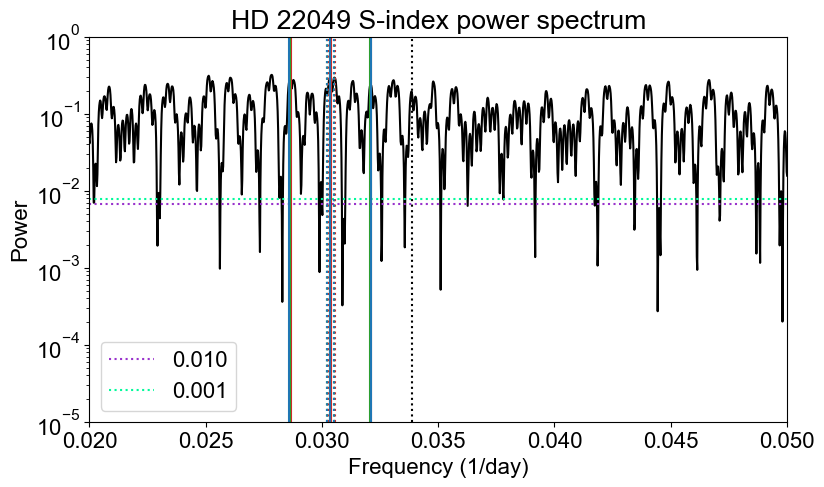

In [63]:
data = pd.read_csv('/Users/haydenatkinson/Downloads/HK_Project_v1995_NSO/22049.mgd', 
                       delim_whitespace=True, header=None, 
                       names=['HD', 'S cal', 'JD-2444000', 'weight', 'KHR', 'Cvr', 'S inst', 'Icode', 'Date', 'UT time'])
data

#data.plot.scatter('JD-2444000', 'S cal')

good_data = np.abs(data['S cal'] - data['S cal'].mean()) < 3*data['S cal'].std()
data = data[good_data]

data_LS = LombScargle(data['JD-2444000'], data['S cal']) # create Lomb-Scargle object
data_f, data_pow = data_LS.autopower() # get frequency grid and power
data_fals = data_LS.false_alarm_level(faprobs)

minimum_frequency = 0.02
maximum_frequency = 0.05

colors = ['darkorchid', 'mediumspringgreen', 'crimson']
plt.figure(figsize=(9,5))
plt.semilogy(data_f, data_pow, color='black')
for i in range(len(data_fals)):
    plt.axhline(data_fals[i], color=colors[i], ls=':', label=f"{faprobs[i]:.3f}")

plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title('HD 22049 S-index power spectrum')
plt.legend(loc='best')
plt.xlim([minimum_frequency, maximum_frequency])
plt.ylim([1e-5, 1])

import time
import scipy as scipy

def getTridents(freq_array, pow_array, rot_range, delta_f, peak_radius, max_arm, Crown, Concave):
    ### Start the clock.
    start = time.time()
    if (rot_range[1] < rot_range[0]):
        print("Error: Invalid Bounds for Rotation Search Interval.")
        return
    elif (len(freq_array) != len(pow_array)):
        print("Error: Non-matching sizes of data arrays.")
        return
    
    print("Maximum peak separation (maximum magnetic activity frequency): {}/day".format(max_arm))
    print("Rotation frequency search interval: [{}/day, {}/day]".format(rot_range[0], rot_range[1]))
    print("Frequency resolution: {}/day".format(delta_f))
    print("Peak radius: {}/day\n".format(peak_radius))
    
    
    ### This function takes in frequency and power arrays and return a list of tridents.
    ### A trident is a collection of three evenly-spaced spikes in the power spectrum.
    ### They are caused by the modulation of the rotation frequency with the magnetic activity frequency.
    
    ### Parameters:
    ### freq_array: An inputted array of frequencies.
    ### pow_array: An inputted array of power values for each frequency in freq_array, representing our power spectrum.
    ### rot_range: The interval of our search. Any trident this function outputs will have a rotation frequency
    ### within this interval.
    ### delta_f: The frequency resolution of our search.
    ### peak_radius: In this function, a peak is treated as having a width double this value. Its purpose is two-fold:
    ### peak evaluations are conducted using this as the upper boundary, and as such the separation between two peaks
    ### should always be at least twice this value.
    ### max_arm: The maximum separation between the side peaks and the central peak.
    ### Crown & Concave: Filters. Their functions are explained later on.
    
    def getIndex(x): return np.argmin(np.abs(freq_array - round(x,6)))
    
    ### Initialize the trident array
    tridents = []
    tridentSum = 0
    
    def line(x, m, n):
        return m*x + n
            
    def analyzePeak(x):
        x = round(x, 6)
        netRadius = int(np.floor(peak_radius/delta_f))
        net = delta_f * np.linspace(-netRadius, netRadius, 2*netRadius + 1)
        
        peakX = [freq_array[getIndex(x)]]
        peakY = [pow_array[getIndex(x)]]
        i=0
        nextI = delta_f
        while(nextI <= peak_radius):
            peakX += [freq_array[getIndex(x - i)]] + [freq_array[getIndex(x + i)]]
            peakY += [pow_array[getIndex(x - i)]] + [pow_array[getIndex(x + i)]]
            i = nextI
            nextI = round(nextI + delta_f, 6)
                
        line_param, line_cov = scipy.optimize.curve_fit(line, peakX, peakY)
                
        base = line_param[0]*freq_array[getIndex(x)] + line_param[1]
        prominence_arr = []
        
        k=0
        while(k < len(net)):
            prominence_arr += [peakY[k] - (line_param[0]*peakX[k] + line_param[1])]
            k += 1
            
        shape = np.mean(prominence_arr)
                
        return base, shape
    
    ### Initialize the frequency values of the middle point (the "head") and the separation between
    ### the head and the side points (the "arm")
    head = round(rot_range[0] - delta_f, 6) ### This represents the rotation frequency.
    arm = 0  ### This represents the magnetic activity frequency.
    
    ### Our "search area" is:
    ### rot_range[0] ≤ head ≤ rot_range[1]
    ### 0 ≤ arm ≤ max_arm
    
    while (head <= rot_range[1]):
        #break
        
        ### incrementor algorithm
        nextArm = round(arm + delta_f, 6)
        nextHead = round(head + delta_f, 6)
        if ((nextArm <= max_arm) and (rot_range[0] <= head)):
            ### incrementing arm
            arm = nextArm
        else:
            ### incrementing head, resetting arm
            head = nextHead
            arm = 0
            
        #print("Looking at: {}, {}".format(round(head, 6), round(arm, 6)))
        
        ### 1. Check for "crowding"
        ### We are gauging whether something is a trident or not based on the "combined heights" of the three peaks.
        ### So, one thing that can happen is that the three limbs end up crowding together in a configuration
        ### that maximizes their combined height. This obviously isn't a trident, so we disqualify those
        ### configurations.
        if (arm <= 2*peak_radius):
            #print("Failed (Crowding): Arm =", round(arm, 5))
            continue
            
        ### 2. De-artifacting
        ### We exclude tridents that benefit from the artifacted peaks at the year-frequency...
        elif ((np.abs(head-arm - 1/365.24) < peak_radius) or (np.abs(head - 1/365.24) < peak_radius) or (np.abs(head+arm - 1/365.24) < peak_radius)):
            #print("Failed: Too close to a year")
            continue
            
        ### and the month-frequency.
        elif ((np.abs(head-arm - 1/29.53) < peak_radius) or (np.abs(head - 1/29.53) < peak_radius) or (np.abs(head+arm - 1/29.53) < peak_radius)):
            #print("Failed: Too close to a month")
            continue
            
        ### A peak has two attributes: its height (base), and its shape.
        leftArmBase, leftArmShape = analyzePeak(head-arm)
        headBase, headShape = analyzePeak(head)
        rightArmBase, rightArmShape = analyzePeak(head+arm)
        
        
        ### 2. Check for "drowning":
        ### If the head is below the false alarm probability level (the "water"), then it is not a trident.
        if (headBase < data_fals[1]):
            #print("Failed (Drowning): Head =", round(head, 5))
            continue
             
        ### 3. Check if the center peak is taller than the side peaks.
        elif (Crown and not((leftArmBase < headBase) and (headBase > rightArmBase))):
            #print("Failed (Arms higher than Head):", round(head, 5), ",", round(arm, 5))
            continue
        
        ### 4. Check if the peaks themselves are locally concave down.
        elif (Concave and not((leftArmShape > 0) and
                           (headShape > 0) and
                           (leftArmShape > 0))):
            #print("Failed (peaks are concave up):", round(head, 5), ",", round(arm, 5))
            continue
        
        ### Once a trident has passed through all of the filters, we can add it to our output array
        else:
            print("Trident Found:", head, ",", arm)
                
            ### In order to evaluate a potential trident, we create a variable tridentScore that is essentially a
            ### measure of how likely it is that the current head-arm pair is a trident based on things
            ### like the heights and sharpness of the peaks.
            
            ### We value height over shape.
            ### That is, a tall and flat peak is worth more than a short and sharp peak.
            ### Put another way, if two peaks have the same height but different "widths",
            ### we value the wider peak more than the thinner one.
            ### x >> y
            ### x > 0
            leftArmScore =  (leftArmBase + leftArmShape) * leftArmBase
            headScore   =   (headBase + headShape) * headBase
            rightArmScore = (rightArmBase + rightArmShape) * rightArmBase
            
            armScore = (leftArmScore * rightArmScore)/(leftArmScore + rightArmScore)
            
            tridentScore = armScore * headScore
            #tridentScore = (armScore * headScore)/(armScore + headScore)
                    
            tridents += [[head, arm, tridentScore]]
            tridentSum += tridentScore
            
            ### Add the trident to the output array and maintain the descending order of tridentScore.
            k = len(tridents)-1
            while((tridents[k-1][2] < tridents[k][2]) and (k > 0)):
                temp = tridents[k-1]
                tridents[k-1] = tridents[k]
                tridents[k] = temp
                k -= 1
    
    ### Stop the clock.
    end = time.time()
    
    ### Print important information.
    print("Time: {} seconds.".format(end-start))
    print("{} tridents found.".format(len(tridents)))
    return tridents
    
### A frequency resolution greater 0.00002 is recommended.
Crown = 0
Concave = 0
rot_range = [1/50, 1/20]
delta_f = 0.000045
peak_radius = 0.00015
max_arm = 1/500
tridents = getTridents(data_f, data_pow, 
                       rot_range, 
                       delta_f, 
                       peak_radius,
                       max_arm,
                       Crown, Concave)

plt.axvline(1/365.24,  ls=':', color='black')
plt.axvline(1/29.53,  ls=':', color='black')

print("The three most likely tridents are:")
print(tridents[0])
print(tridents[1])
print(tridents[2])

print("\nThe three least likely tridents are:")
print(tridents[-3])
print(tridents[-2])
print(tridents[-1])

plt.axvline(tridents[0][0], color='tab:red')
plt.axvline(tridents[0][0]+tridents[0][1], color='tab:red')
plt.axvline(tridents[0][0]-tridents[0][1], color='tab:red')
plt.axvline(tridents[0][1], ls='--', color='tab:red')

plt.axvline(tridents[0][0]+peak_radius, ls=':', color='tab:red')
plt.axvline(tridents[0][0]-peak_radius, ls=':', color='tab:red')

plt.axvline(tridents[1][0], color='tab:green')
plt.axvline(tridents[1][0]+tridents[1][1], color='tab:green')
plt.axvline(tridents[1][0]-tridents[1][1], color='tab:green')
plt.axvline(tridents[1][1], ls='--', color='tab:green')

plt.axvline(tridents[1][0]+peak_radius, ls=':', color='tab:green')
plt.axvline(tridents[1][0]-peak_radius, ls=':', color='tab:green')

plt.axvline(tridents[2][0], color='tab:blue')
plt.axvline(tridents[2][0]+tridents[2][1], color='tab:blue')
plt.axvline(tridents[2][0]-tridents[2][1], color='tab:blue')
plt.axvline(tridents[2][1], ls='--', color='tab:blue')

plt.axvline(tridents[2][0]+peak_radius, ls=':', color='tab:blue')
plt.axvline(tridents[2][0]-peak_radius, ls=':', color='tab:blue')

# 107213  (rotation, magnetic) = (0.00273, 0.00037)
# 143761  (rotation, magnetic) = (0.002925, 0.00033) (middle peak has less power than left and right peaks)
# 13421   (rotation, magnetic) = (0.002675, 0.0006)
# 187013  (rotation, magnetic) = (0.002365, 0.00033) or  (0.00543, 0.00063)
# 149661  (rotation, magnetic) = (0.00295, 0.0005)
# 216385  (rotation, magnetic) = (0.004865, 0.00055) or  (0.004865, 0.00025) or (0.0026, 0.00055) or (0.03345, 0.00278)
# 187691  (rotation, magnetic) = (0.002425, 0.00025) or  (0.0031, 0.00067) or (0.0191, 0.00137)
# 39587   (rotation, magnetic) = (0.0039, 0.00035) or    (0.0021, 0.00045) or (0.02394, 0.00271)
# 131156A (rotation, magnetic) = (0.003025, 0.001125) or (0.003, 0.0005) or (0.01435, 0.00273)
# 212754  (rotation, magnetic) = (0.00275, 0.0002) or (0.00255, 0.0004) (five-pronged fork centered on 0.00255) or (0.02027, 0.0027)
# 124570  (rotation, magnetic) = (0.00571, 0.00033) or (0.003, 0.0004)

In [399]:
window = np.ones_like(data['JD-2444000'].to_numpy())
freqs = np.linspace(0, 0.5, 1025, endpoint=True)[1:]
window_power = LombScargle(data['JD-2444000'].to_numpy(), window, center_data=False, fit_mean=False, 
                           normalization='psd').power(freqs)

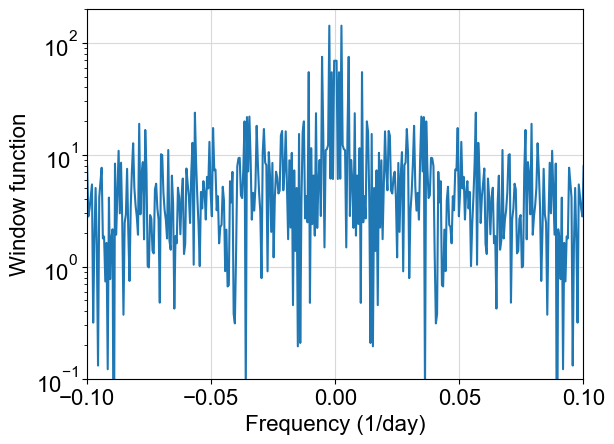

In [548]:
plt.semilogy(np.concatenate((-freqs[::-1],freqs)), np.concatenate((window_power[::-1], window_power)))
plt.xlabel('Frequency (1/day)')
plt.ylabel('Window function')
plt.xlim([-0.1,0.1])
plt.ylim([0.1,200])
plt.grid(color='0.85')